# **Predicción de Conversión de Leads Usando Machine Learning**
### **Introducción**

En la era digital, las empresas enfrentan el desafío constante de identificar y priorizar a los clientes con mayor probabilidad de conversión. El análisis de datos masivos y la automatización de procesos han permitido abordar este desafío mediante modelos avanzados de Machine Learning.

En este proyecto, exploramos la predicción de conversión de leads, una tarea fundamental en estrategias de marketing digital. Utilizando técnicas como **Random Forest** y **XGBoost**, diseñaremos un modelo capaz de clasificar leads con base en características relevantes, optimizando así las decisiones estratégicas.

### **Objetivos del Proyecto**
- Desarrollar un modelo de Machine Learning que prediga la probabilidad de conversión de un lead.
- Implementar un flujo de trabajo de datos realista, incluyendo procesos **ETL** y el uso de herramientas como **Google BigQuery** para la gestión y transformación de datos.
- Comparar el rendimiento de modelos clásicos como Random Forest con algoritmos avanzados como XGBoost.
- Crear una solución aplicable al entorno empresarial, capaz de ser integrada en procesos automatizados.

### **Flujo de Trabajo**
1. **Preparación del Dataset**: Limpieza, análisis exploratorio y transformación de los datos.
2. **Entrenamiento de Modelos**: Construcción de modelos de clasificación y ajuste de hiperparámetros.
3. **Evaluación de Resultados**: Uso de métricas como precisión, F1-Score y AUC-ROC para comparar modelos.
4. **Visualización e Implementación**: Creación de dashboards interactivos y automatización del pipeline.

Este notebook no solo busca resolver un problema técnico, sino también ofrecer un marco replicable y aplicable en el ámbito real, donde los insights generados por el modelo pueden traducirse en acciones empresariales efectivas.


In [585]:
#Importar librerias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import io
import os
from google.cloud import bigquery
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [586]:
# Importar librerías necesarias
from google.cloud import storage, bigquery
import os
import pandas as pd
import io

# Configuración del bucket y credenciales
BUCKET_NAME = "tfg_credencial"
CREDENTIALS_FILE = "tfg-key.json"
LOCAL_CREDENTIALS_PATH = "/tmp/credentials.json"

# Función para descargar credenciales desde GCS
def download_credentials():
    if not os.path.exists(LOCAL_CREDENTIALS_PATH):
        client = storage.Client()
        bucket = client.bucket(BUCKET_NAME)
        blob = bucket.blob(CREDENTIALS_FILE)

        print("Descargando credenciales desde GCS...")
        blob.download_to_filename(LOCAL_CREDENTIALS_PATH)
        print("Credenciales descargadas y guardadas en:", LOCAL_CREDENTIALS_PATH)
    else:
        print("Credenciales ya existen en el sistema.")

    # Configurar credenciales en la variable de entorno
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = LOCAL_CREDENTIALS_PATH
    print("Credenciales configuradas en GOOGLE_APPLICATION_CREDENTIALS.")

# Llamar a la función para descargar credenciales
download_credentials()

# Inicializar el cliente de BigQuery
client = bigquery.Client()

# Nombre de la tabla en BigQuery
table_id = "future-loader-433707-h4.leads.cleaned_leads"

# Consultar los datos de la tabla
query = f"SELECT * FROM `{table_id}`"

try:
    # Ejecutar la consulta y convertir el resultado a un DataFrame
    query_job = client.query(query)
    df = query_job.result().to_dataframe()

    # Guardar el DataFrame en un archivo CSV en memoria
    memory_file = io.StringIO()
    df.to_csv(memory_file, index=False)
    memory_file.seek(0)

    # Leer el archivo en memoria nuevamente como un DataFrame
    data_frame_leads = pd.read_csv(memory_file)
    print("Tabla cargada en memoria y leída en una variable temporal (DataFrame).")
except Exception as e:
    print(f"Error al descargar la tabla: {e}")

# Configuración para mejorar la visualización del DataFrame
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.max_rows', 20)       # Número de filas (ajustable)
pd.set_option('display.width', 1000)        # Evitar saltos de línea
print(data_frame_leads.head())  # Imprimir las primeras filas formateadas


Credenciales ya existen en el sistema.
Credenciales configuradas en GOOGLE_APPLICATION_CREDENTIALS.


/Users/dylangerra/.pyenv/versions/3.10.10/envs/gauss-entorno/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Tabla cargada en memoria y leída en una variable temporal (DataFrame).
   Lead Number              Lead Origin Lead Source  Converted  Total Time Spent on Website  Page Views Per Visit              Last Activity What is your current occupation  A free copy of Mastering The Interview                Tags          City Asymmetrique Activity Index Asymmetrique Profile Index  Asymmetrique Activity Score  Asymmetrique Profile Score Last Notable Activity  TotalVisits  Country           Specialization  Average Time Per Visit
0       115325  Landing Page Submission         NaN          1                            9                  0.06    Olark Chat Conversation            Working Professional                                   False             Unknown        Mumbai                   02.Medium                    01.High                          NaN                        16.0              SMS Sent          0.0  Unknown    Media and Advertising                     NaN
1       546831           

 # **1.Preparación del Dataset**: 

In [587]:
#Revisión general del data frame
print(data_frame_leads.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170503 entries, 0 to 170502
Data columns (total 20 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Lead Number                             170503 non-null  int64  
 1   Lead Origin                             170503 non-null  object 
 2   Lead Source                             169898 non-null  object 
 3   Converted                               170503 non-null  int64  
 4   Total Time Spent on Website             170503 non-null  int64  
 5   Page Views Per Visit                    170503 non-null  float64
 6   Last Activity                           168565 non-null  object 
 7   What is your current occupation         170503 non-null  object 
 8   A free copy of Mastering The Interview  170503 non-null  bool   
 9   Tags                                    170503 non-null  object 
 10  City                                    1705

In [588]:
print(data_frame_leads.isnull().sum())

Lead Number                                   0
Lead Origin                                   0
Lead Source                                 605
Converted                                     0
Total Time Spent on Website                   0
Page Views Per Visit                          0
Last Activity                              1938
What is your current occupation               0
A free copy of Mastering The Interview        0
Tags                                          0
City                                          0
Asymmetrique Activity Index               77741
Asymmetrique Profile Index                78033
Asymmetrique Activity Score               78039
Asymmetrique Profile Score                78285
Last Notable Activity                         0
TotalVisits                                   0
Country                                       0
Specialization                                0
Average Time Per Visit                    23448
dtype: int64


In [589]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview       bool
Tags                                       object
City                                       object
Asymmetrique Activity Index                object
Asymmetrique Profile Index                 object
Asymmetrique Activity Score               float64
Asymmetrique Profile Score                float64
Last Notable Activity                      object
TotalVisits                               float64
Country                                    object
Specialization                             object
Average Time Per Visit                    float64


In [590]:
data_frame_leads.describe()

,Lead Number,Converted,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,TotalVisits,Average Time Per Visit
count,170503.000000,170503.000000,170503.000000,170503.000000,92464.000000,92218.000000,170503.000000,147055.000000
mean,549504.911702,0.402016,271.842525,1.535069,14.269034,16.345703,2.136432,97.400038
std,260346.916733,0.490307,378.263760,1.559383,1.036372,1.813199,1.706724,95.459651
min,100002.000000,0.000000,1.000000,0.000000,10.000000,11.000000,0.000000,0.500000
25%,323290.000000,0.000000,10.000000,0.290000,14.000000,15.000000,1.000000,19.500000
50%,550179.000000,0.000000,84.000000,0.920000,14.000000,16.000000,2.000000,68.000000
75%,774903.000000,1.000000,400.000000,2.380000,15.000000,18.000000,3.000000,151.333333
max,999996.000000,1.000000,2143.000000,6.000000,18.000000,20.000000,10.000000,1264.000000


In [591]:
print(data_frame_leads['Specialization'].value_counts())

print("------------------------REVISAR PORCENTAJES DE SELECT EN LA COLUMNA DE SPECIALIZATION-----------------------------")

porcentaje_select = (data_frame_leads['Specialization'] == 'Select').mean() * 100
print(f"Porcentaje de 'Select': {porcentaje_select:.2f}%")

print("------------------------------------------ANALISIS DE LA TASA DE CONVERSION----------------------------------------")

conversion_select = data_frame_leads[data_frame_leads['Specialization'] == 'Select']['Converted'].mean()
print(f"Tasa de conversión para 'Select': {conversion_select:.2f}")


Specialization
Select                               38532
Finance Management                   19597
Marketing Management                 16727
Human Resource Management            16697
Unknown                              15682
Operations Management                 9855
Business Administration               8007
IT Projects Management                7183
Supply Chain Management               6970
Banking, Investment And Insurance     6820
Media and Advertising                 3997
Travel and Tourism                    3913
International Business                3574
Healthcare Management                 3137
E-COMMERCE                            2276
Hospitality Management                2127
Retail Management                     2048
Rural and Agribusiness                1488
E-Business                            1126
Services Excellence                    747
Name: count, dtype: int64
------------------------REVISAR PORCENTAJES DE SELECT EN LA COLUMNA DE SPECIALIZATION--------------

Si el modelo aprende que los leads con "Select" tienen una tasa de conversión extremadamente baja, solo estará utilizando este dato como un indicador trivial y no como una característica que realmente aporte valor para predecir conversiones en general.

Esto podría derivar en un modelo que:

Detecte patrones obvios: Como "Si Specialization = Select, entonces conversión ≈ 0".
Pierda generalización: Porque el modelo no estaría aprendiendo sobre las características relevantes de los leads que realmente convierten.

In [592]:
# Eliminar filas donde 'Specialization' sea 'Select'
data_frame_leads = data_frame_leads[data_frame_leads['Specialization'] != 'Select']

# Verificar el tamaño del dataset después
print(f"Cantidad de filas después de eliminar 'Select': {len(data_frame_leads)}")


Cantidad de filas después de eliminar 'Select': 131971


In [593]:
# Verificar columnas con valores nulos
print(data_frame_leads.isnull().sum())

print("--------------COLUMNAS CON UN VALOR ALTO DE NULOS---------------")
# Analizar el porcentaje de valores nulos por columna
percent_missing = (data_frame_leads.isnull().sum() / len(data_frame_leads)) * 100
print(percent_missing)

#Analizando el volumen de nulos que tienen las columnas y viendo que no nos van  a aportar nada a los modeos de Machine Learning se van a eliminar las columnas con un 40 por ciento de valore nulos

# Eliminar columnas con más del 40% de valores nulos
columns_to_drop = percent_missing[percent_missing > 40].index
data_frame_leads.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Columnas eliminadas: {list(columns_to_drop)}")




Lead Number                                   0
Lead Origin                                   0
Lead Source                                 459
Converted                                     0
Total Time Spent on Website                   0
Page Views Per Visit                          0
Last Activity                              1506
What is your current occupation               0
A free copy of Mastering The Interview        0
Tags                                          0
City                                          0
Asymmetrique Activity Index               60233
Asymmetrique Profile Index                60493
Asymmetrique Activity Score               60383
Asymmetrique Profile Score                60751
Last Notable Activity                         0
TotalVisits                                   0
Country                                       0
Specialization                                0
Average Time Per Visit                    18124
dtype: int64
--------------COLUMNAS CON 

In [594]:
# Reemplazar valores nulos en columnas categóricas y numéricas
data_frame_leads['City'].fillna('Unknown', inplace=True)
data_frame_leads['What is your current occupation'].fillna('Unknown', inplace=True)
data_frame_leads['Tags'].fillna('Unknown', inplace=True)

# Para numéricos, utilizar la media
data_frame_leads['Page Views Per Visit'].fillna(data_frame_leads['Page Views Per Visit'].mean(), inplace=True)
data_frame_leads['Last Activity'].fillna('Unknown', inplace=True)

print("Valores nulos reemplazados correctamente.")


Valores nulos reemplazados correctamente.


/var/folders/9f/2dqd0jwj1gx3t_n_0tk79_180000gq/T/ipykernel_46580/234581487.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_frame_leads['City'].fillna('Unknown', inplace=True)
/var/folders/9f/2dqd0jwj1gx3t_n_0tk79_180000gq/T/ipykernel_46580/234581487.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [595]:
# Eliminar filas con valores nulos en columnas críticas
data_frame_leads.dropna(subset=['Lead Source'], inplace=True)
print(f"Cantidad de filas después de eliminar filas con nulos: {len(data_frame_leads)}")

#Poner la media en los pocos valores nulos que hay en la dimension Average Time Per Visit
data_frame_leads['Average Time Per Visit'].fillna(data_frame_leads['Average Time Per Visit'].mean(), inplace=True)


print("-------------------------------------VALIDAR QUE NO QUEDAN VALORES NULOS--------------------------------")

# Verificar que no quedan valores nulos
print(data_frame_leads.isnull().sum())



Cantidad de filas después de eliminar filas con nulos: 131512
-------------------------------------VALIDAR QUE NO QUEDAN VALORES NULOS--------------------------------
Lead Number                               0
Lead Origin                               0
Lead Source                               0
Converted                                 0
Total Time Spent on Website               0
Page Views Per Visit                      0
Last Activity                             0
What is your current occupation           0
A free copy of Mastering The Interview    0
Tags                                      0
City                                      0
Last Notable Activity                     0
TotalVisits                               0
Country                                   0
Specialization                            0
Average Time Per Visit                    0
dtype: int64


/var/folders/9f/2dqd0jwj1gx3t_n_0tk79_180000gq/T/ipykernel_46580/3282544490.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_frame_leads['Average Time Per Visit'].fillna(data_frame_leads['Average Time Per Visit'].mean(), inplace=True)


# **1.1 Analisis mediante graficas de cada dimension**

**LEAD ORIGIN**

In [596]:
data_frame_leads['Lead Origin'].unique()

array(['Lead Add Form', 'Landing Page Submission', 'Lead Import', 'API',
       'Quick Add Form'], dtype=object)

In [597]:
data_frame_leads['Lead Origin'].value_counts()

Lead Origin
Landing Page Submission    70520
API                        49603
Lead Add Form              10532
Lead Import                  847
Quick Add Form                10
Name: count, dtype: int64

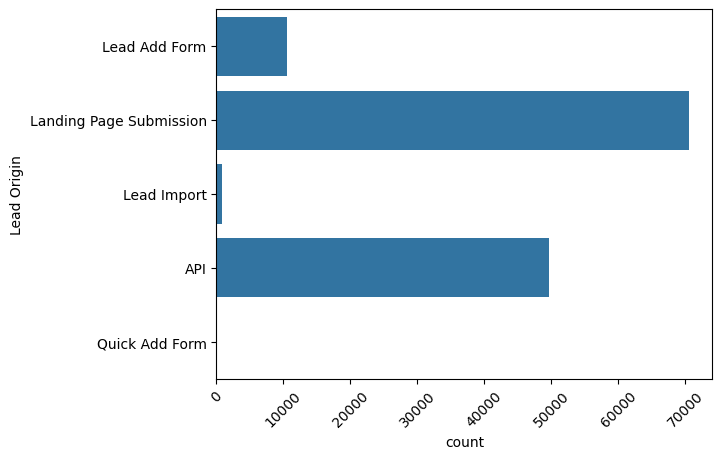

In [598]:
sns.countplot(data_frame_leads['Lead Origin'])
plt.xticks(rotation=45)
plt.show()

**Lead Source**

In [599]:
data_frame_leads['Lead Source'].unique()

array(['bing', 'blog', 'Google', 'NC_EDM', 'google', 'WeLearn', 'testone',
       'Facebook', 'Live Chat', 'Reference', 'Click2call', 'Olark Chat',
       'Social Media', 'Press_Release', 'Direct Traffic',
       'Organic Search', 'Referral Sites', 'youtubechannel',
       'Welingak Website', 'welearnblog_Home', 'Pay per Click Ads'],
      dtype=object)

In [600]:
data_frame_leads['Lead Source'].value_counts()

Lead Source
Google            43202
Direct Traffic    37575
Olark Chat        21834
Organic Search    16129
Reference          7681
                  ...  
blog                 12
testone              11
WeLearn              11
youtubechannel       11
NC_EDM                9
Name: count, Length: 21, dtype: int64

In [601]:
data_frame_leads['Lead Source'] = data_frame_leads['Lead Source'].fillna("Google")

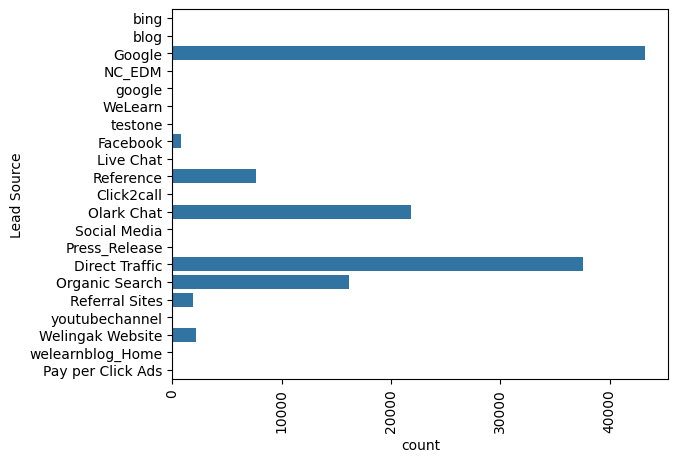

In [602]:
sns.countplot(data_frame_leads['Lead Source'])
plt.xticks(rotation=90)
plt.show()

In [603]:
#Revisando por porcentaje de distribución
LeadSourceCol=(data_frame_leads['Lead Source'].value_counts()*100)/data_frame_leads.shape[0]
LeadSourceCol

Lead Source
Google            32.850234
Direct Traffic    28.571537
Olark Chat        16.602287
Organic Search    12.264280
Reference          5.840532
                    ...    
blog               0.009125
testone            0.008364
WeLearn            0.008364
youtubechannel     0.008364
NC_EDM             0.006843
Name: count, Length: 21, dtype: float64

In [604]:
#Cargar columnas que tengan menos de 10% de los valores
LeadSourceCol=LeadSourceCol[LeadSourceCol<10]
LeadSourceCol

Lead Source
Reference            5.840532
Welingak Website     1.612781
Referral Sites       1.429527
Facebook             0.564207
google               0.056269
bing                 0.055508
Click2call           0.038780
Social Media         0.021291
Live Chat            0.015208
Press_Release        0.013687
Pay per Click Ads    0.012166
welearnblog_Home     0.010645
blog                 0.009125
testone              0.008364
WeLearn              0.008364
youtubechannel       0.008364
NC_EDM               0.006843
Name: count, dtype: float64

Como vemos hay muchas columnas que no nos aportan nada porque aparecen muy muy pocas veces, por lo que lo suyo es construir un dato llamado " other source" que las haga referencia a ellas.

In [605]:
for i in LeadSourceCol.index:
    data_frame_leads.loc[(data_frame_leads['Lead Source'] == i),'Lead Source']='Other Source'

In [606]:
#Revisando porcentajes de distribucion para corrobar que hemos reducido el ruido de esta columna
(data_frame_leads['Lead Source'].value_counts()*100)/data_frame_leads.shape[0]

Lead Source
Google            32.850234
Direct Traffic    28.571537
Olark Chat        16.602287
Organic Search    12.264280
Other Source       9.711661
Name: count, dtype: float64

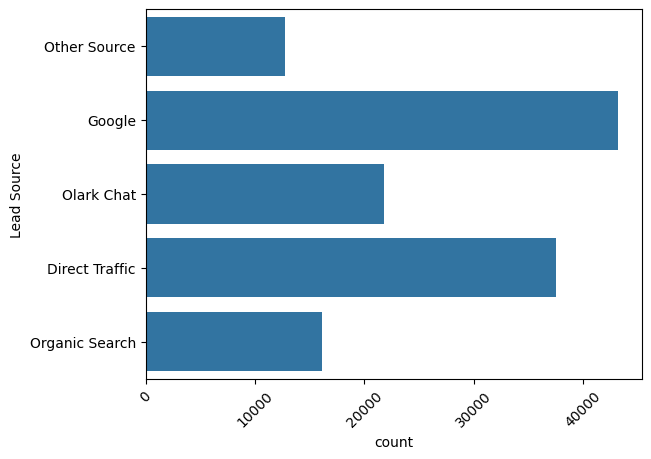

In [607]:
sns.countplot(data_frame_leads['Lead Source'])
plt.xticks(rotation=45)
plt.show()

**Last Activity**

In [608]:
data_frame_leads['Last Activity'].unique()

array(['SMS Sent', 'Email Opened', 'Page Visited on Website',
       'Olark Chat Conversation', 'Email Bounced', 'Email Link Clicked',
       'Unsubscribed', 'Converted to Lead', 'Approached upfront',
       'Unknown', 'Unreachable', 'Form Submitted on Website',
       'Had a Phone Conversation', 'View in browser link Clicked',
       'Email Marked Spam', 'Email Received',
       'Visited Booth in Tradeshow', 'Resubscribed to emails'],
      dtype=object)

In [609]:
data_frame_leads['Last Activity'].value_counts()

Last Activity
Email Opened                    48857
SMS Sent                        39114
Olark Chat Conversation         13685
Page Visited on Website          9196
Converted to Lead                6049
Email Bounced                    4686
Email Link Clicked               3749
Form Submitted on Website        1717
Unknown                          1502
Unreachable                      1319
Unsubscribed                      931
Had a Phone Conversation          405
Approached upfront                127
View in browser link Clicked       93
Email Received                     30
Resubscribed to emails             18
Email Marked Spam                  17
Visited Booth in Tradeshow         17
Name: count, dtype: int64

In [610]:
#Llenamos posibles nulos con el valor mas comun en la columna Last Activity
data_frame_leads['Last Activity'] = data_frame_leads['Last Activity'].replace(np.nan, 'Email Opened')

In [611]:
data_frame_leads['Last Activity'].value_counts()

Last Activity
Email Opened                    48857
SMS Sent                        39114
Olark Chat Conversation         13685
Page Visited on Website          9196
Converted to Lead                6049
Email Bounced                    4686
Email Link Clicked               3749
Form Submitted on Website        1717
Unknown                          1502
Unreachable                      1319
Unsubscribed                      931
Had a Phone Conversation          405
Approached upfront                127
View in browser link Clicked       93
Email Received                     30
Resubscribed to emails             18
Email Marked Spam                  17
Visited Booth in Tradeshow         17
Name: count, dtype: int64

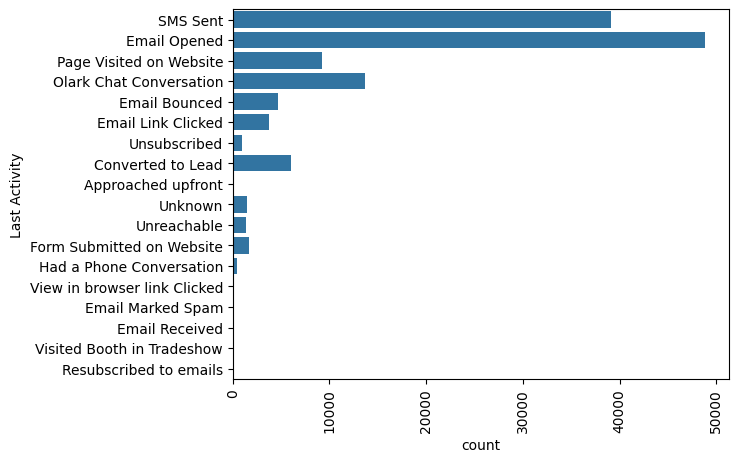

In [612]:
sns.countplot(data_frame_leads['Last Activity'])
plt.xticks(rotation=90)
plt.show()

In [613]:
#Revisando el porcentaje de distribucion de esta columna
LastActivityCol=(data_frame_leads['Last Activity'].value_counts()*100)/data_frame_leads.shape[0]
LastActivityCol

Last Activity
Email Opened                    37.150222
SMS Sent                        29.741773
Olark Chat Conversation         10.405895
Page Visited on Website          6.992518
Converted to Lead                4.599580
Email Bounced                    3.563173
Email Link Clicked               2.850690
Form Submitted on Website        1.305584
Unknown                          1.142101
Unreachable                      1.002950
Unsubscribed                     0.707920
Had a Phone Conversation         0.307957
Approached upfront               0.096569
View in browser link Clicked     0.070716
Email Received                   0.022812
Resubscribed to emails           0.013687
Email Marked Spam                0.012927
Visited Booth in Tradeshow       0.012927
Name: count, dtype: float64

In [614]:
#Last Activity Columns having less than 5% values
LastActivityCol=LastActivityCol[LastActivityCol<5]
LastActivityCol

Last Activity
Converted to Lead               4.599580
Email Bounced                   3.563173
Email Link Clicked              2.850690
Form Submitted on Website       1.305584
Unknown                         1.142101
Unreachable                     1.002950
Unsubscribed                    0.707920
Had a Phone Conversation        0.307957
Approached upfront              0.096569
View in browser link Clicked    0.070716
Email Received                  0.022812
Resubscribed to emails          0.013687
Email Marked Spam               0.012927
Visited Booth in Tradeshow      0.012927
Name: count, dtype: float64

In [615]:
for i in LastActivityCol.index:
    data_frame_leads.loc[(data_frame_leads['Last Activity'] == i),'Last Activity']='Other Last Activity'

In [616]:
#Checking for percantage of distibution
(data_frame_leads['Last Activity'].value_counts()*100)/data_frame_leads.shape[0]

Last Activity
Email Opened               37.150222
SMS Sent                   29.741773
Other Last Activity        15.709593
Olark Chat Conversation    10.405895
Page Visited on Website     6.992518
Name: count, dtype: float64

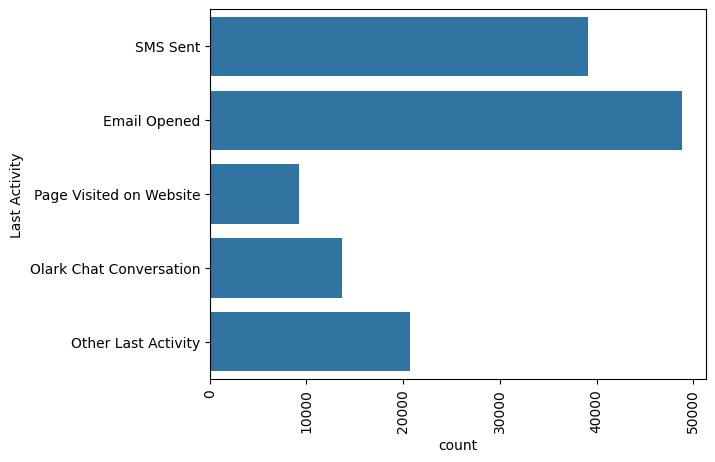

In [617]:
sns.countplot(data_frame_leads['Last Activity'])
plt.xticks(rotation=90)
plt.show()

**5.Country**

In [618]:
data_frame_leads['Country'].unique()

array(['Unknown', 'India', 'Canada', 'United Arab Emirates', 'Australia',
       'United States', 'Singapore', 'United Kingdom', 'Qatar',
       'Saudi Arabia', 'Hong Kong', 'Uganda', 'Kuwait', 'Russia',
       'Netherlands', 'Sweden', 'Belgium', 'France', 'Switzerland',
       'Bahrain', 'Germany', 'South Africa', 'Nigeria', 'unknown', 'Oman',
       'China', 'Ghana', 'Asia/Pacific Region', 'Italy', 'Kenya',
       'Philippines', 'Sri Lanka', 'Liberia', 'Tanzania', 'Denmark',
       'Indonesia', 'Bangladesh'], dtype=object)

In [619]:
data_frame_leads['Country'].value_counts()

Country
India                   106689
Unknown                  22878
United States              560
United Arab Emirates       467
Saudi Arabia               152
                         ...  
Philippines                  1
Tanzania                     1
Denmark                      1
Indonesia                    1
Bangladesh                   1
Name: count, Length: 37, dtype: int64

In [620]:
#Los valores Na se sustituyen por el dato que mas aparece en este caso India
data_frame_leads['Country'] = data_frame_leads['Country'].fillna("India")

In [621]:
data_frame_leads['Country'].unique()

array(['Unknown', 'India', 'Canada', 'United Arab Emirates', 'Australia',
       'United States', 'Singapore', 'United Kingdom', 'Qatar',
       'Saudi Arabia', 'Hong Kong', 'Uganda', 'Kuwait', 'Russia',
       'Netherlands', 'Sweden', 'Belgium', 'France', 'Switzerland',
       'Bahrain', 'Germany', 'South Africa', 'Nigeria', 'unknown', 'Oman',
       'China', 'Ghana', 'Asia/Pacific Region', 'Italy', 'Kenya',
       'Philippines', 'Sri Lanka', 'Liberia', 'Tanzania', 'Denmark',
       'Indonesia', 'Bangladesh'], dtype=object)

In [622]:
data_frame_leads['Country'].value_counts()

Country
India                   106689
Unknown                  22878
United States              560
United Arab Emirates       467
Saudi Arabia               152
                         ...  
Philippines                  1
Tanzania                     1
Denmark                      1
Indonesia                    1
Bangladesh                   1
Name: count, Length: 37, dtype: int64

In [623]:
# borramos la columna country porque solo  hay datos de la india y ademas el otro volumen mas cuantioso es desconocido
data_frame_leads.drop(labels='Country',axis=1,inplace=True)

**6.Specialization**

In [624]:
data_frame_leads['Specialization'].unique()

array(['Business Administration', 'Operations Management',
       'Finance Management', 'Marketing Management', 'Unknown',
       'IT Projects Management', 'Human Resource Management',
       'Healthcare Management', 'Banking, Investment And Insurance',
       'International Business', 'E-COMMERCE', 'E-Business',
       'Supply Chain Management', 'Media and Advertising',
       'Hospitality Management', 'Rural and Agribusiness',
       'Travel and Tourism', 'Services Excellence', 'Retail Management'],
      dtype=object)

In [625]:
data_frame_leads['Specialization'] = data_frame_leads['Specialization'].replace(np.nan, 'Others')

In [626]:
data_frame_leads['Specialization'].value_counts()

Specialization
Finance Management                   19513
Marketing Management                 16673
Human Resource Management            16642
Unknown                              15626
Operations Management                 9826
Business Administration               7973
IT Projects Management                7156
Supply Chain Management               6951
Banking, Investment And Insurance     6803
Media and Advertising                 3982
Travel and Tourism                    3901
International Business                3566
Healthcare Management                 3124
E-COMMERCE                            2266
Hospitality Management                2119
Retail Management                     2039
Rural and Agribusiness                1483
E-Business                            1123
Services Excellence                    746
Name: count, dtype: int64

In [627]:
#Checking for percantage of distibution
OtherCol=(data_frame_leads['Specialization'].value_counts()*100)/data_frame_leads.shape[0]
OtherCol

Specialization
Finance Management                   14.837429
Marketing Management                 12.677931
Human Resource Management            12.654359
Unknown                              11.881805
Operations Management                 7.471562
Business Administration               6.062565
IT Projects Management                5.441329
Supply Chain Management               5.285449
Banking, Investment And Insurance     5.172912
Media and Advertising                 3.027861
Travel and Tourism                    2.966269
International Business                2.711540
Healthcare Management                 2.375449
E-COMMERCE                            1.723037
Hospitality Management                1.611260
Retail Management                     1.550429
Rural and Agribusiness                1.127654
E-Business                            0.853914
Services Excellence                   0.567249
Name: count, dtype: float64

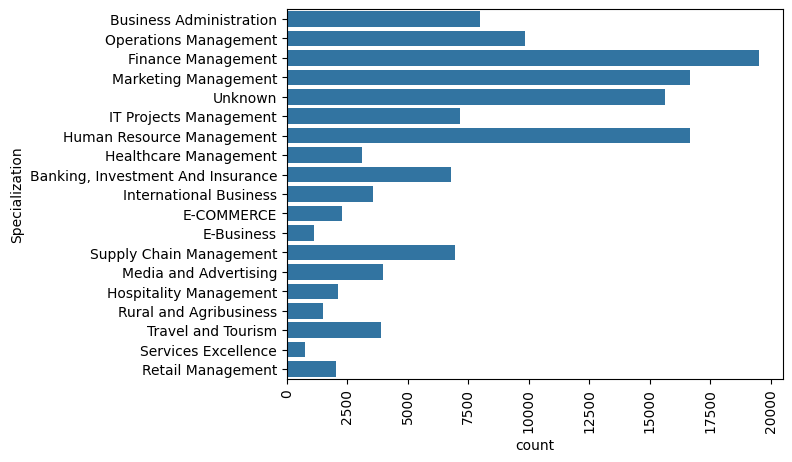

In [628]:
sns.countplot(data_frame_leads['Specialization'])
plt.xticks(rotation=90)
plt.show()

In [629]:
#Agrupamos los datos en una sola variable llamada Others cuando tienen un volumen inferior al 2% respecto a el volumen total de la columna Specialization

OtherCol=OtherCol[OtherCol<2]
for i in OtherCol.index:
    data_frame_leads.loc[(data_frame_leads['Specialization'] == i),'Specialization']='Others'
#Checking for percantage of distibution
(data_frame_leads['Specialization'].value_counts()*100)/data_frame_leads.shape[0]


Specialization
Finance Management                   14.837429
Marketing Management                 12.677931
Human Resource Management            12.654359
Unknown                              11.881805
Operations Management                 7.471562
Others                                7.433542
Business Administration               6.062565
IT Projects Management                5.441329
Supply Chain Management               5.285449
Banking, Investment And Insurance     5.172912
Media and Advertising                 3.027861
Travel and Tourism                    2.966269
International Business                2.711540
Healthcare Management                 2.375449
Name: count, dtype: float64

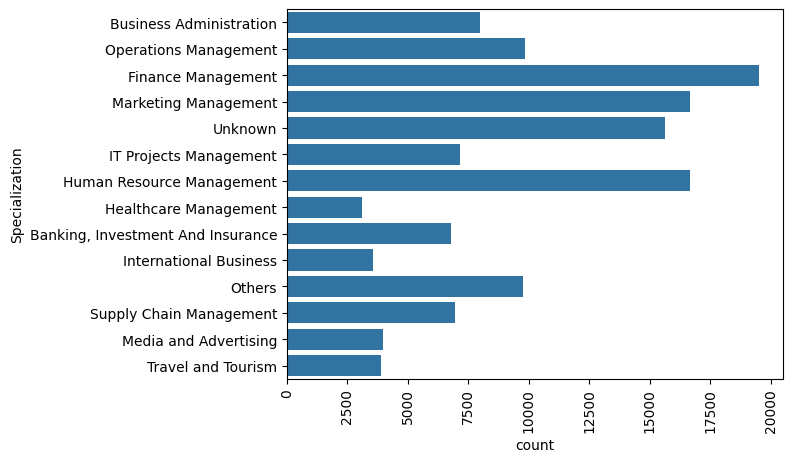

In [630]:
sns.countplot(data_frame_leads['Specialization'])
plt.xticks(rotation=90)
plt.show()

**7. WHAT IS YOUR CURRENT OCCUPATION**

In [631]:
data_frame_leads['What is your current occupation'].unique()

array(['Unemployed', 'Working Professional', 'Unknown', 'Student',
       'Housewife', 'Other', 'Businessman'], dtype=object)

In [632]:
data_frame_leads['What is your current occupation'].value_counts()

What is your current occupation
Unemployed              102236
Working Professional     12953
Unknown                  11800
Student                   3871
Other                      301
Housewife                  199
Businessman                152
Name: count, dtype: int64

In [633]:
data_frame_leads['What is your current occupation'] = data_frame_leads['What is your current occupation'].fillna("Unemployed")

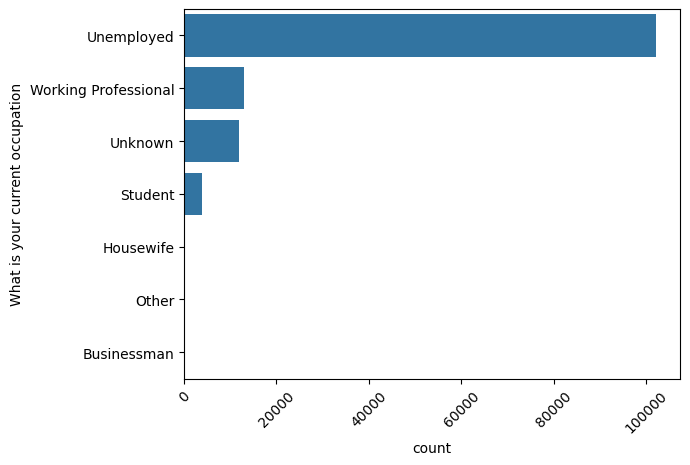

In [634]:
sns.countplot(data_frame_leads['What is your current occupation'])
plt.xticks(rotation=45)
plt.show()

In [635]:
#Revisando porcentaje de distribucion
LeadSourceCol=(data_frame_leads['What is your current occupation'].value_counts()*100)/data_frame_leads.shape[0]
LeadSourceCol

What is your current occupation
Unemployed              77.738914
Working Professional     9.849291
Unknown                  8.972565
Student                  2.943458
Other                    0.228876
Housewife                0.151317
Businessman              0.115579
Name: count, dtype: float64

**8. TAGS**

In [636]:
data_frame_leads['Tags'].unique()


array(['Ringing', 'Will revert after reading the email',
       'Interested in other courses', 'Interested in Next batch', 'Busy',
       'Lost to EINS', 'Closed by Horizzon', 'invalid number',
       'Graduation in progress', 'Unknown', 'Already a student',
       'Not doing further education',
       'Shall take in the next coming month',
       'Interested  in full time MBA', 'switched off',
       'Diploma holder (Not Eligible)', 'opp hangup', 'Lateral student',
       'number not provided', 'wrong number given', 'in touch with EINS',
       'Still Thinking', 'Recognition issue (DEC approval)',
       'Lost to Others',
       'Want to take admission but has financial problems',
       'In confusion whether part time or DLP',
       'University not recognized'], dtype=object)

In [637]:
data_frame_leads['Tags'].value_counts()

Tags
Will revert after reading the email    41874
Ringing                                24655
Unknown                                11852
Interested in other courses            10360
Already a student                       9477
                                       ...  
Interested in Next batch                  97
Lateral student                           68
Shall take in the next coming month       52
University not recognized                 44
Recognition issue (DEC approval)          25
Name: count, Length: 27, dtype: int64

In [638]:
#"Will revert after reading the email" is coming the most times , hence replacing NaN value with value this.
data_frame_leads['Tags'] = data_frame_leads['Tags'].fillna("Will revert after reading the email")

In [639]:
data_frame_leads['Tags'].value_counts()

Tags
Will revert after reading the email    41874
Ringing                                24655
Unknown                                11852
Interested in other courses            10360
Already a student                       9477
                                       ...  
Interested in Next batch                  97
Lateral student                           68
Shall take in the next coming month       52
University not recognized                 44
Recognition issue (DEC approval)          25
Name: count, Length: 27, dtype: int64

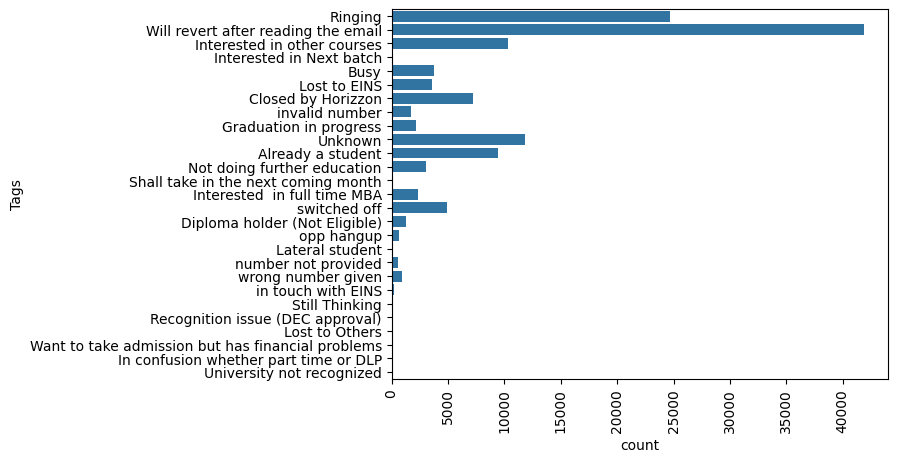

In [640]:
sns.countplot(data_frame_leads['Tags'])
plt.xticks(rotation=90)
plt.show()

In [641]:
#Checking for percantage of distibution
TagsCol=(data_frame_leads['Tags'].value_counts()*100)/data_frame_leads.shape[0]
TagsCol

Tags
Will revert after reading the email    31.840440
Ringing                                18.747339
Unknown                                 9.012105
Interested in other courses             7.877608
Already a student                       7.206187
                                         ...    
Interested in Next batch                0.073758
Lateral student                         0.051706
Shall take in the next coming month     0.039540
University not recognized               0.033457
Recognition issue (DEC approval)        0.019010
Name: count, Length: 27, dtype: float64

In [642]:
#Tags Columns que tienen menos de 3% values
TagsCol=TagsCol[TagsCol<3]
for i in TagsCol.index:
    data_frame_leads.loc[(data_frame_leads['Tags'] == i),'Tags']='Other Tags'

In [643]:
#Revisando de nuevo la distribución
(data_frame_leads['Tags'].value_counts()*100)/data_frame_leads.shape[0]

Tags
Will revert after reading the email    31.840440
Ringing                                18.747339
Other Tags                             16.046444
Unknown                                 9.012105
Interested in other courses             7.877608
Already a student                       7.206187
Closed by Horizzon                      5.502920
switched off                            3.766957
Name: count, dtype: float64

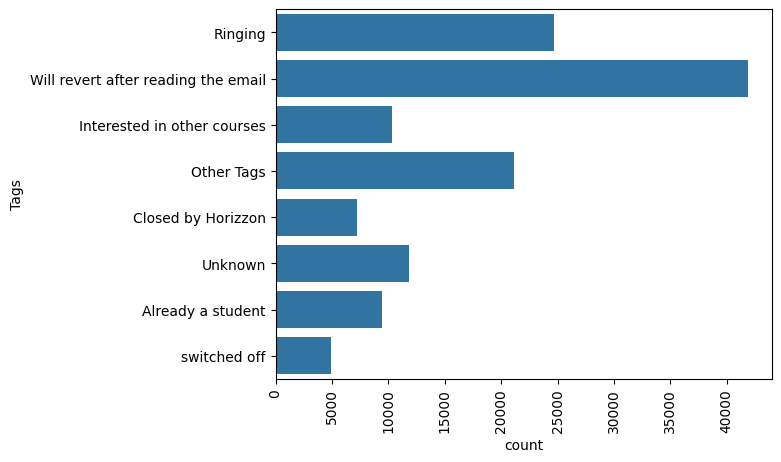

In [644]:
sns.countplot(data_frame_leads['Tags'])
plt.xticks(rotation=90)
plt.show()

**9. A FREE COPY OF MASTERING THE INTERVIEW**

In [645]:
data_frame_leads['A free copy of Mastering The Interview'].unique()

array([False,  True])

In [646]:
data_frame_leads['A free copy of Mastering The Interview'].value_counts()

A free copy of Mastering The Interview
False    88415
True     43097
Name: count, dtype: int64

/var/folders/9f/2dqd0jwj1gx3t_n_0tk79_180000gq/T/ipykernel_46580/4056837565.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='muted')


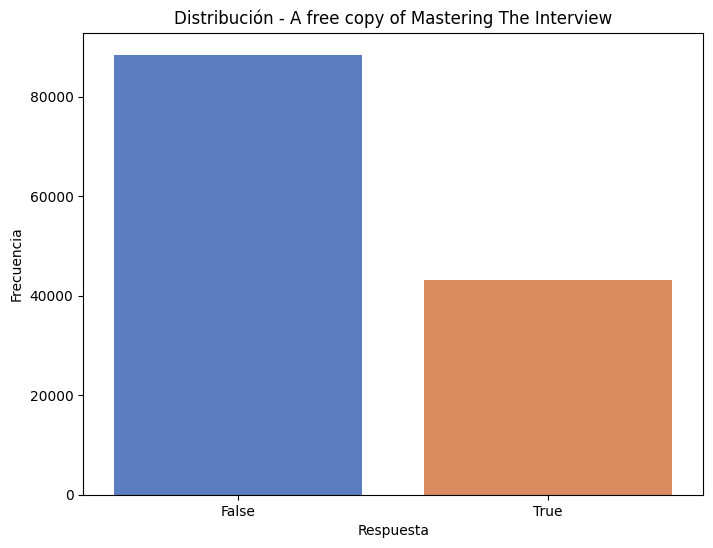

In [647]:

# Agrupar por valor y contar
counts = data_frame_leads['A free copy of Mastering The Interview'].value_counts()

# Graficar usando barplot en lugar de countplot
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, palette='muted')

# Título y etiquetas
plt.title('Distribución - A free copy of Mastering The Interview')
plt.xlabel('Respuesta')
plt.ylabel('Frecuencia')

plt.show()


**10. LAST NOTABLE ACTIVITY**

In [648]:
data_frame_leads['Last Notable Activity'].unique()

array(['SMS Sent', 'Modified', 'Page Visited on Website', 'Email Opened',
       'Email Link Clicked', 'Olark Chat Conversation', 'Unsubscribed',
       'Unreachable', 'Email Bounced', 'Had a Phone Conversation',
       'Email Received', 'Email Marked Spam',
       'View in browser link Clicked', 'Resubscribed to emails',
       'Form Submitted on Website', 'Approached upfront'], dtype=object)

In [649]:
data_frame_leads['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                        48488
Email Opened                    39742
SMS Sent                        31442
Page Visited on Website          4490
Email Link Clicked               2524
Olark Chat Conversation          2494
Email Bounced                     856
Unsubscribed                      686
Unreachable                       475
Had a Phone Conversation          196
Email Marked Spam                  30
Email Received                     23
View in browser link Clicked       21
Form Submitted on Website          19
Resubscribed to emails             13
Approached upfront                 13
Name: count, dtype: int64

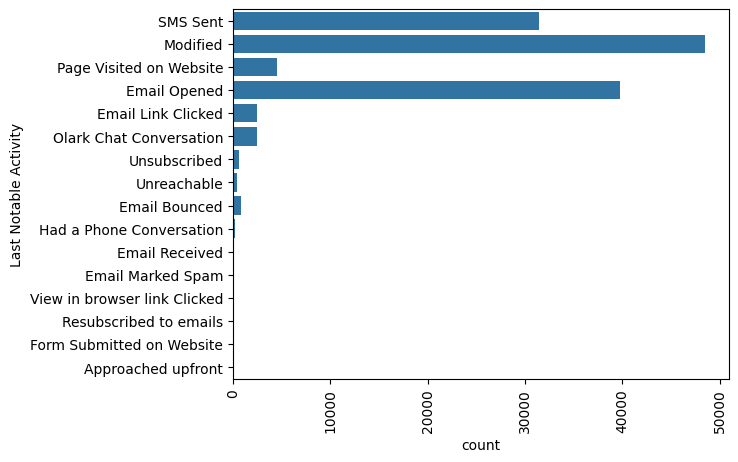

In [650]:
sns.countplot(data_frame_leads['Last Notable Activity'])
plt.xticks(rotation=90)
plt.show()

In [651]:
#Revisando el porcentaje de distribucion
OtherCol=(data_frame_leads['Last Notable Activity'].value_counts()*100)/data_frame_leads.shape[0]
OtherCol

Last Notable Activity
Modified                        36.869639
Email Opened                    30.219296
SMS Sent                        23.908084
Page Visited on Website          3.414137
Email Link Clicked               1.919216
Olark Chat Conversation          1.896405
Email Bounced                    0.650891
Unsubscribed                     0.521625
Unreachable                      0.361184
Had a Phone Conversation         0.149036
Email Marked Spam                0.022812
Email Received                   0.017489
View in browser link Clicked     0.015968
Form Submitted on Website        0.014447
Resubscribed to emails           0.009885
Approached upfront               0.009885
Name: count, dtype: float64

In [652]:
#Agrupando las variables inferiores al 5 por ciento en una sola para reducir ruido
OtherCol=OtherCol[OtherCol<5]
for i in OtherCol.index:
    data_frame_leads.loc[(data_frame_leads['Last Notable Activity'] == i),'Last Notable Activity']='Other Activity'
#Checking for percantage of distibution
(data_frame_leads['Last Notable Activity'].value_counts()*100)/data_frame_leads.shape[0]

Last Notable Activity
Modified          36.869639
Email Opened      30.219296
SMS Sent          23.908084
Other Activity     9.002981
Name: count, dtype: float64

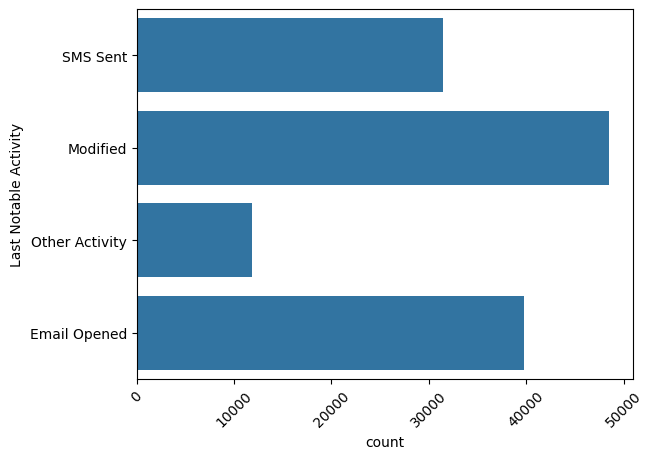

In [653]:
sns.countplot(data_frame_leads['Last Notable Activity'])
plt.xticks(rotation=45)
plt.show()

**11.CITY**

In [654]:
data_frame_leads['City'].unique()

array(['Select', 'Mumbai', 'Thane & Outskirts', 'Other Cities',
       'Other Cities of Maharashtra', 'Other Metro Cities',
       'Tier II Cities'], dtype=object)

In [655]:
data_frame_leads['City'].value_counts()

City
Mumbai                         54237
Select                         37707
Thane & Outskirts              12524
Other Cities                   11646
Other Cities of Maharashtra     7709
Other Metro Cities              6409
Tier II Cities                  1280
Name: count, dtype: int64

In [656]:
# value - Mumbai
data_frame_leads['City'] = data_frame_leads['City'].fillna("Mumbai")

In [657]:
data_frame_leads['City'].value_counts()

City
Mumbai                         54237
Select                         37707
Thane & Outskirts              12524
Other Cities                   11646
Other Cities of Maharashtra     7709
Other Metro Cities              6409
Tier II Cities                  1280
Name: count, dtype: int64

In [658]:
#Revisando el porcentaje de distribucion
data_frame_leads['City'].value_counts()*100/data_frame_leads.shape[0]

City
Mumbai                         41.241103
Select                         28.671908
Thane & Outskirts               9.523085
Other Cities                    8.855466
Other Cities of Maharashtra     5.861822
Other Metro Cities              4.873320
Tier II Cities                  0.973295
Name: count, dtype: float64

**REVISAR LOS VALORES NUMERICOS DE CADA DIMENSION**

**1.LEAD NUMBER**

count    131512.000000
mean     549390.875000
std      260241.421875
min      100002.000000
25%      323146.250000
50%      549928.500000
75%      775047.750000
max      999996.000000
Name: Lead Number, dtype: float64

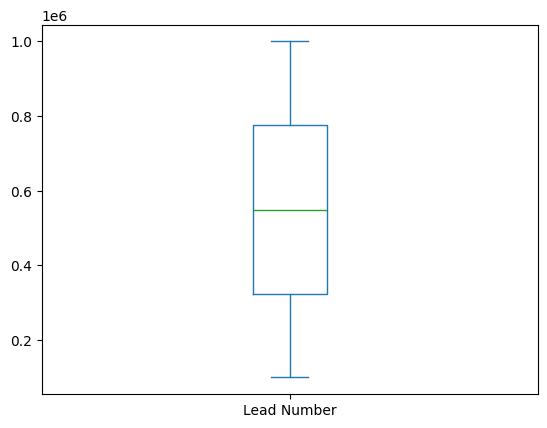

In [659]:
converted = pd.to_numeric(data_frame_leads["Lead Number"],downcast='float',errors='coerce')
converted.plot(kind='box')
converted.describe()
#Tiene sentido porque es un identificador para el lead

**2.Total Visits**

count    131512.000000
mean          2.133007
std           1.707228
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          10.000000
Name: TotalVisits, dtype: float64

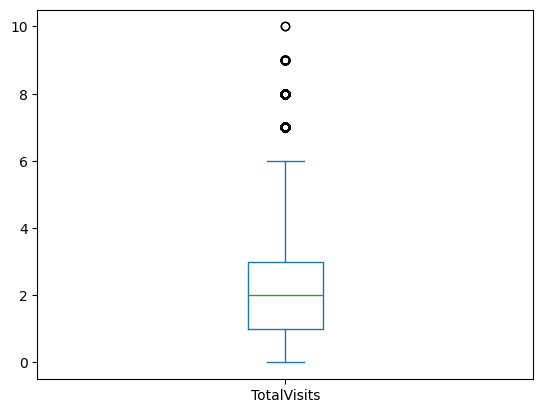

In [660]:
converted =pd.to_numeric(data_frame_leads["TotalVisits"],downcast='float',errors='coerce') # error coerce sirve para que te solicione errores si el CSV esta mal hecho.
converted.plot(kind='box')
converted.describe()

**3. Page Views Per Visit**

count    131512.000000
mean          1.530822
std           1.559745
min           0.000000
25%           0.290000
50%           0.910000
75%           2.380000
max           6.000000
Name: Page Views Per Visit, dtype: float64

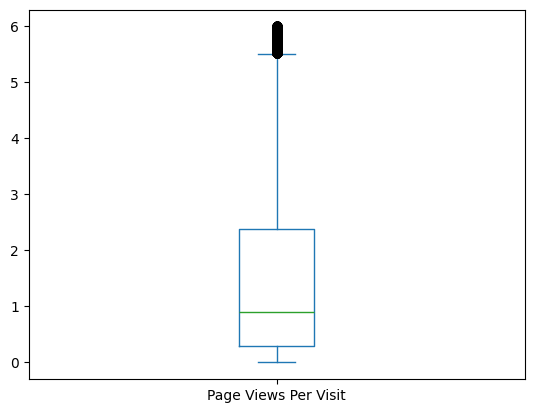

In [661]:
converted =pd.to_numeric(data_frame_leads["Page Views Per Visit"],downcast='float',errors='coerce') # error coerce sirve para que te solicione errores si el CSV esta mal hecho.
converted.plot(kind='box')
converted.describe()


**4.Total Time Spent on Website**

In [662]:
data_frame_leads['Total Time Spent on Website'].describe()

count    131512.000000
mean        270.829476
std         377.622957
min           1.000000
25%          10.000000
50%          83.000000
75%         399.000000
max        2143.000000
Name: Total Time Spent on Website, dtype: float64

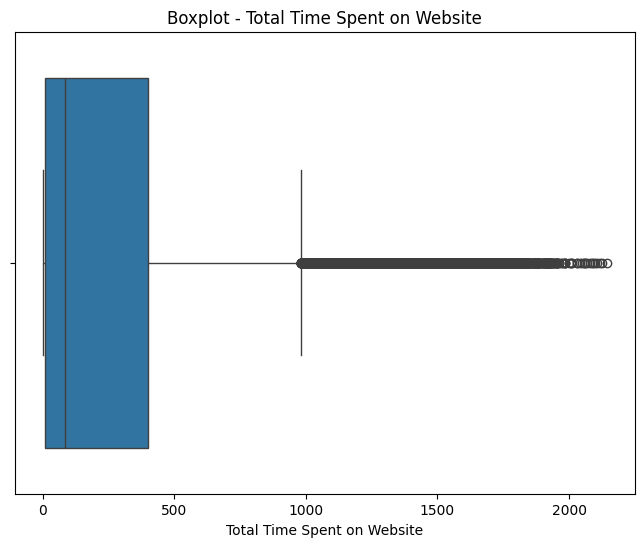

In [663]:
# Asegurar que no haya valores infinitos
data_frame_leads.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar valores nulos si los hay (Esto lo mantenemos para evitar errores en la visualización)
data_frame_leads.dropna(subset=['Total Time Spent on Website'], inplace=True)

# Visualización inicial con boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_frame_leads['Total Time Spent on Website'])
plt.title('Boxplot - Total Time Spent on Website')
plt.show()

# Comentado: Análisis estadístico de outliers
# desc_stats = data_frame_leads['Total Time Spent on Website'].describe()
# Q1 = desc_stats['25%']
# Q3 = desc_stats['75%']
# IQR = Q3 - Q1  # Rango intercuartílico
# limite_inferior = Q1 - 1.5 * IQR
# limite_superior = Q3 + 1.5 * IQR

# print(f"Límite inferior: {limite_inferior}")
# print(f"Límite superior: {limite_superior}")

# outliers = data_frame_leads[(data_frame_leads['Total Time Spent on Website'] > limite_superior) |
#                             (data_frame_leads['Total Time Spent on Website'] < limite_inferior)]
# print(f"Número de outliers detectados: {len(outliers)}")

# Método 1: Eliminar outliers (Comentado)
# data_frame_sin_outliers = data_frame_leads[(data_frame_leads['Total Time Spent on Website'] <= limite_superior) &
#                                            (data_frame_leads['Total Time Spent on Website'] >= limite_inferior)]

# Método 2: Limitar outliers (Comentado)
# data_frame_winsorized = data_frame_leads.copy()
# data_frame_winsorized['Total Time Spent on Website'] = np.where(
#     data_frame_winsorized['Total Time Spent on Website'] > limite_superior,
#     limite_superior,
#     np.where(
#         data_frame_winsorized['Total Time Spent on Website'] < limite_inferior,
#         limite_inferior,
#         data_frame_winsorized['Total Time Spent on Website']
#     )
# )


**Explicaciones de porque se va a trabajar con outliners**
Los modelos de ML de Random Forest y XGboost no son sensibles a los datos fuera de lo común además estos datos pueden dar luz al modelo para entender cuando un usuario (lead) va a hacer una conversion, fijandose en la cantidad de tiempo que pasa en la web.

## EDA -> ANALISIS EXPLORATORIO DE DATOS ##

**UNIVARIATE ANALYSIS**

**1. Variables Categóricas**

In [664]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview       bool
Tags                                       object
City                                       object
Last Notable Activity                      object
TotalVisits                               float64
Specialization                             object
Average Time Per Visit                    float64
dtype: object

In [665]:
#Decido pasar el bool a object para mejorar la calidad del dato y comprension
# Convertir booleano a object
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].astype(str)


In [666]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview     object
Tags                                       object
City                                       object
Last Notable Activity                      object
TotalVisits                               float64
Specialization                             object
Average Time Per Visit                    float64
dtype: object

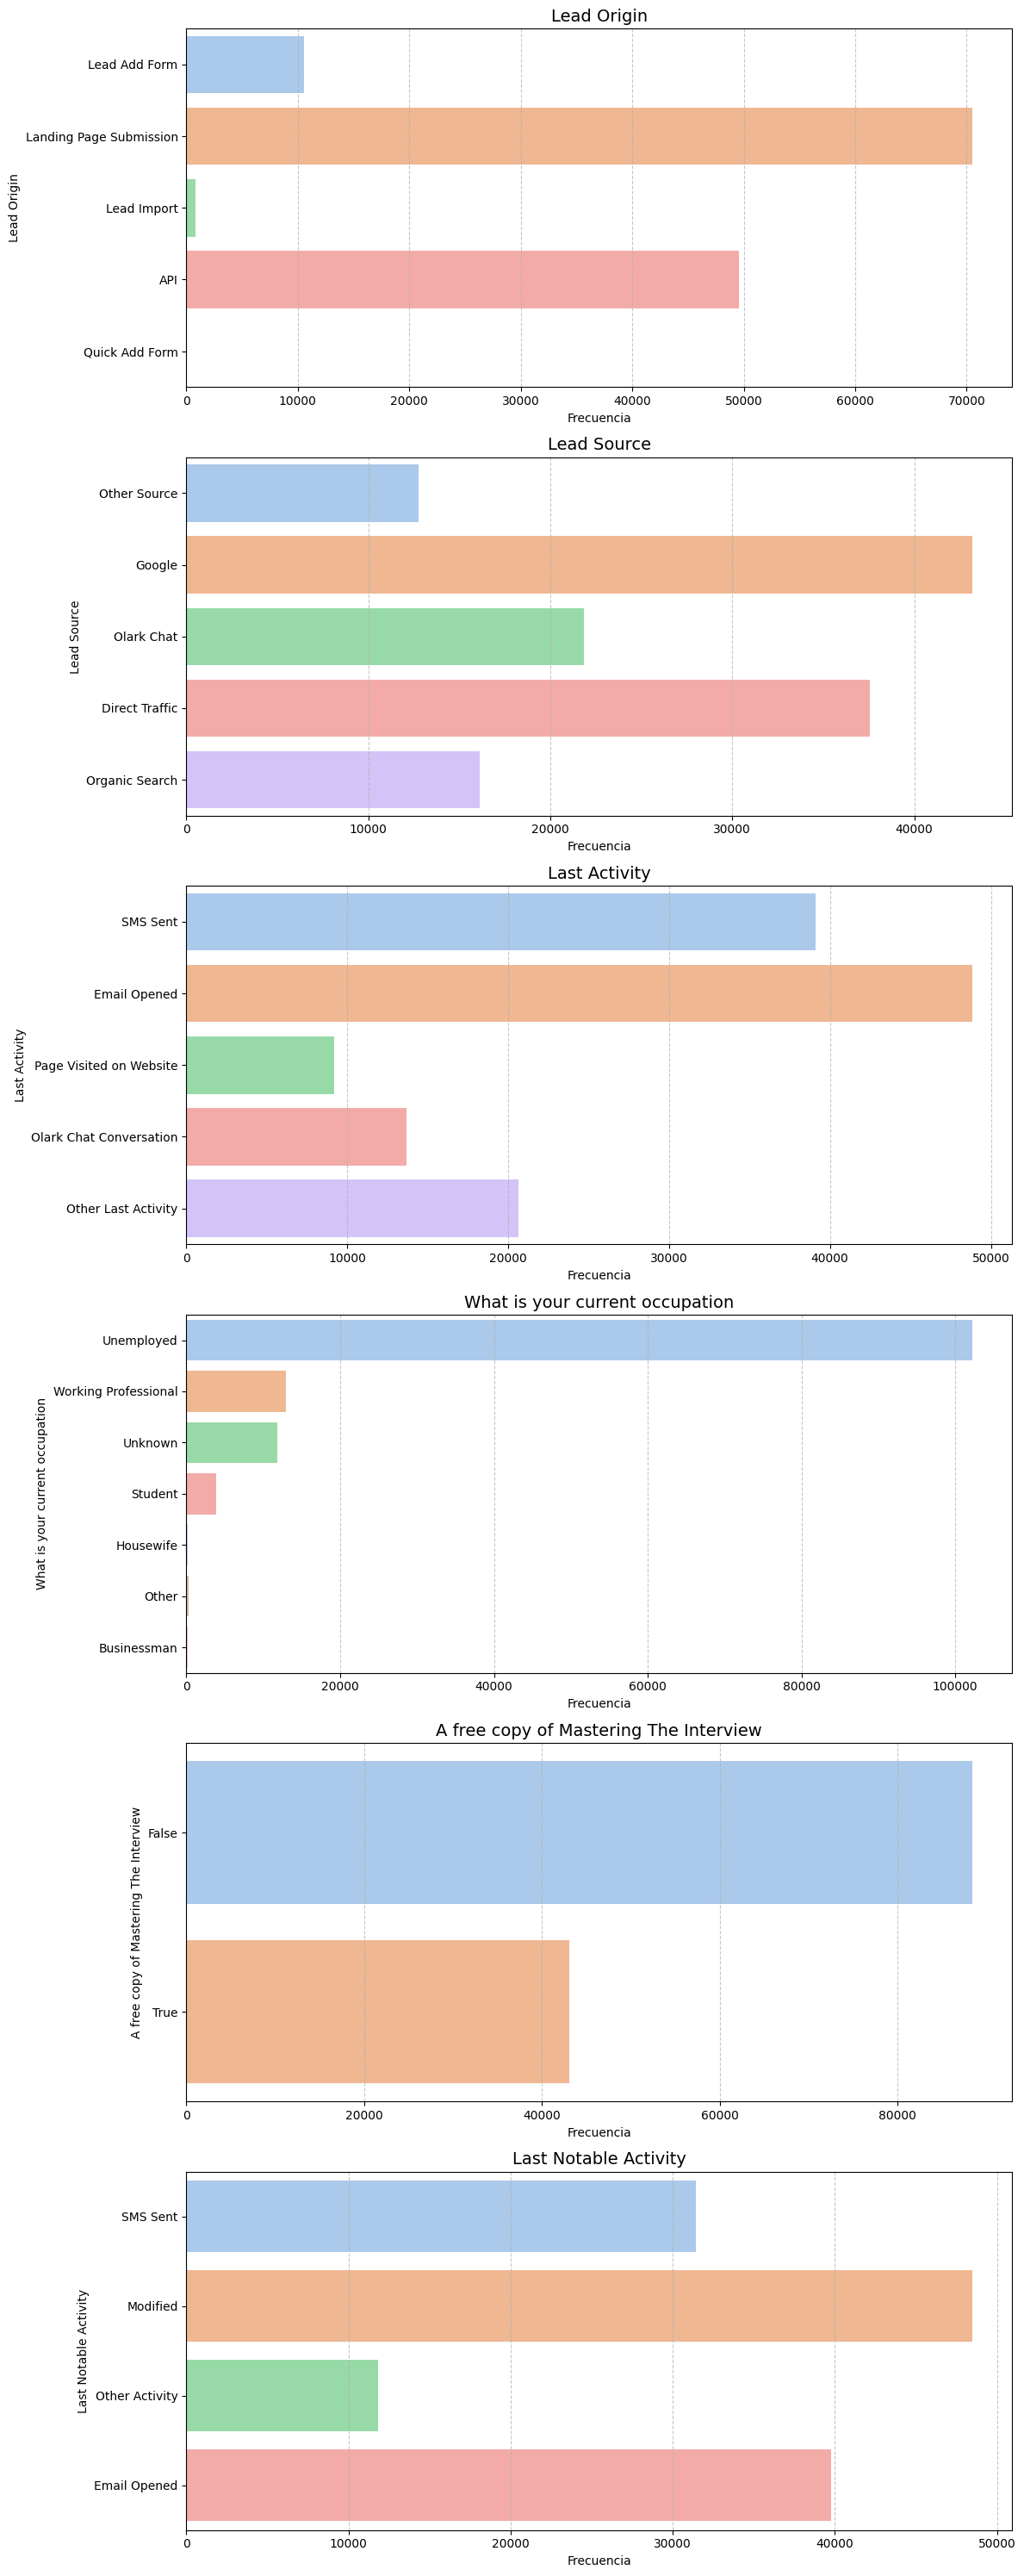

In [667]:
plt.figure(figsize=(12, 30))  # Ajustamos el tamaño para una disposición vertical

columns = [
    'Lead Origin',
    'Lead Source',
    'Last Activity',
    'What is your current occupation',
    'A free copy of Mastering The Interview',
    'Last Notable Activity'
]

# Generar gráficos verticales
for i, column in enumerate(columns, 1):
    plt.subplot(len(columns), 1, i)  # 1 columna, tantas filas como gráficas
    
    # Calcular colores basados en categorías únicas
    num_classes = data_frame_leads[column].nunique()  # Número de categorías únicas
    colors = sns.color_palette('pastel', n_colors=num_classes)  # Generar colores exactos
    
    sns.countplot(y=data_frame_leads[column], hue=data_frame_leads[column], palette=colors, legend=False)
    
    plt.title(column, fontsize=14)
    plt.xlabel('Frecuencia')  # Etiqueta del eje X
    plt.ylabel(column)  # Etiqueta del eje Y
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Observaciones del Análisis Exploratorio de Datos (EDA)

## 1. Lead Origin (Origen del Lead)
- **Observación Principal**: La mayoría de los leads provienen de "Landing Page Submission" y "API".  
- **Interpretación**:  
  - Las **páginas de aterrizaje** parecen ser la principal fuente de generación de leads.  
  - La API también es una fuente importante, lo que sugiere automatización o integración con otros sistemas.  
  - **Lead Add Form** y **Lead Import** tienen una contribución menor, lo que puede indicar que son canales menos efectivos o utilizados.

---

## 2. Lead Source (Fuente del Lead)
- **Observación Principal**: "Google" y "Direct Traffic" dominan como fuentes principales de leads.  
- **Interpretación**:  
  - El tráfico orgánico y directo representan la mayor parte de los leads.  
  - "Olark Chat" también tiene una presencia significativa, lo que sugiere que la interacción en vivo puede ser clave en la captación de leads.  
  - **Fuentes menos comunes** podrían representar nichos o esfuerzos de marketing menos efectivos.

---

## 3. Last Activity (Última Actividad)
- **Observación Principal**: "Email Opened" y "SMS Sent" son las actividades más frecuentes.  
- **Interpretación**:  
  - Los leads parecen responder más a correos electrónicos y mensajes SMS, lo que indica que estos canales son efectivos.  
  - Actividades como "Page Visited on Website" tienen menos frecuencia, pero siguen siendo relevantes.

---

## 4. What is your Current Occupation (Ocupación Actual)
- **Observación Principal**:  
  - La mayoría de los leads están **desempleados** o tienen un estado **desconocido**.  
  - "Working Professional" también representa una parte considerable.  
- **Interpretación**:  
  - El alto número de desempleados puede indicar que el producto o servicio se dirige a personas que buscan mejorar sus habilidades o encontrar trabajo.  
  - La categoría **"Unknown"** debería investigarse más a fondo, ya que podría haber falta de información relevante que afecte el análisis.

---

## 5. A Free Copy of Mastering The Interview (Copia Gratuita de "Mastering The Interview")
- **Observación Principal**:  
  - La mayoría de los leads **no** solicitan una copia gratuita.  
- **Interpretación**:  
  - Puede que el recurso no sea atractivo o no se promocione correctamente.  
  - La conversión en aquellos que sí solicitan la copia es notablemente mayor, lo que indica que este grupo tiene más interés.

---

## 6. Last Notable Activity (Última Actividad Notable)
- **Observación Principal**:  
  - Las actividades más comunes son "Email Opened" y "Modified".  
- **Interpretación**:  
  - El seguimiento por correo electrónico sigue siendo un canal crucial.  
  - La actividad **"Modified"** puede reflejar leads que han actualizado información o interactuado recientemente con la plataforma.

---

## Reflexión Final
- **Los valores "Unknown"** están presentes en varias variables (especialmente en **Occupación** y **Ciudad**).  
- Es importante evaluar si estos valores deben ser tratados (imputación) o si pueden mantenerse, ya que el modelo debe reflejar datos del mundo real, donde no siempre se tiene toda la información.  


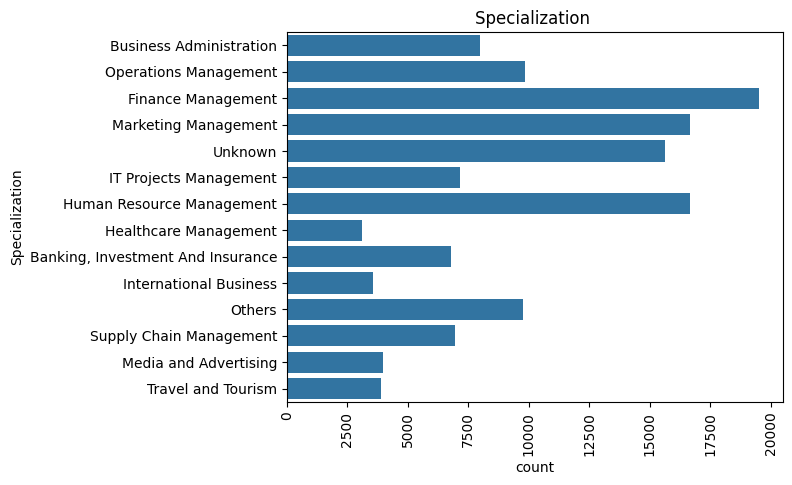

In [668]:
sns.countplot(data_frame_leads['Specialization'])
plt.title('Specialization ')
plt.xticks(rotation=90)
plt.show()

# Observaciones: Especialización

## Especialización (Specialization)
- **Observación Clave**:  
  - La mayoría de los leads tienen una especialización **desconocida (Unknown)**.  
  - Las especializaciones más comunes después de "Unknown" son **Finance Management** y **Human Resource Management**.  
- **Interpretación**:  
  - Es posible que muchos leads no completen este campo, lo que sugiere una brecha en la recopilación de datos.  
  - Las áreas de **gestión financiera y de recursos humanos** parecen atraer la mayor atención.  

- **Recomendación**:  
  - Considerar estrategias para incentivar a los usuarios a completar esta información, ya que puede ser valiosa para la segmentación de leads.  


/var/folders/9f/2dqd0jwj1gx3t_n_0tk79_180000gq/T/ipykernel_46580/3936043565.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tags_counts.values, y=tags_counts.index, palette="viridis")


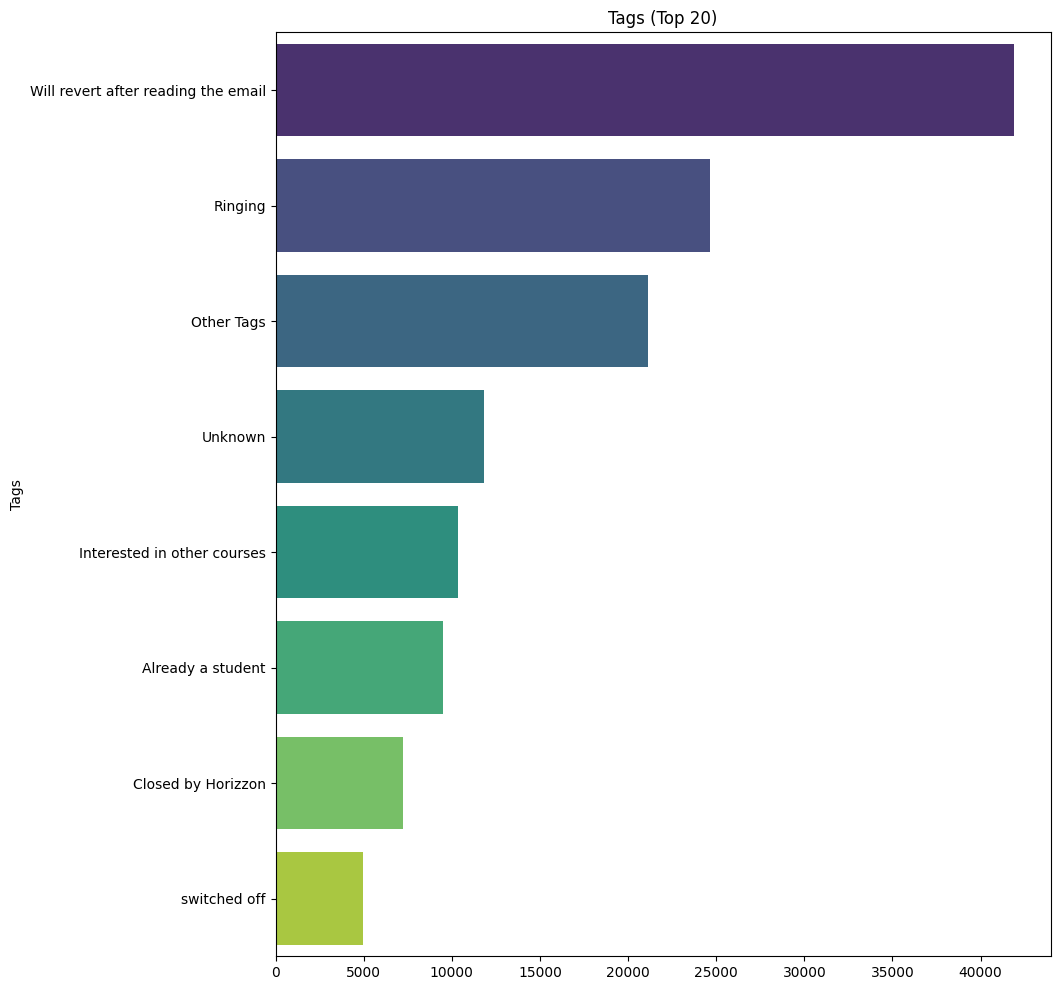

In [669]:
data_sample = data_frame_leads.sample(10000)  # 10,000 filas aleatorias

plt.figure(figsize=(10, 12))

tags_counts = data_frame_leads['Tags'].value_counts().nlargest(20)  # Top 20 Tags
sns.barplot(x=tags_counts.values, y=tags_counts.index, palette="viridis")
plt.title('Tags (Top 20)')
plt.show()


# Observaciones: Tags

## Tags (Top 20)
- **Observación Clave**:  
  - El tag más frecuente es **"Unknown"**, lo que representa una gran parte de los datos.  
  - Tags relevantes como **"Will revert after reading the email"** y **"Other Tags"** también destacan, pero con una frecuencia significativamente menor.  
- **Interpretación**:  
  - La alta proporción de "Unknown" puede indicar que muchos leads no están etiquetados adecuadamente o el proceso de seguimiento es incompleto.  
  - La categoría **"Will revert after reading the email"** sugiere que una porción de los leads necesita más tiempo antes de tomar decisiones.  

- **Recomendación**:  
  - Es necesario **mejorar la recolección de datos y reducir la cantidad de "Unknown"** a través de un etiquetado más riguroso y procesos de seguimiento más efectivos.  


/var/folders/9f/2dqd0jwj1gx3t_n_0tk79_180000gq/T/ipykernel_46580/2747208311.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette="magma")


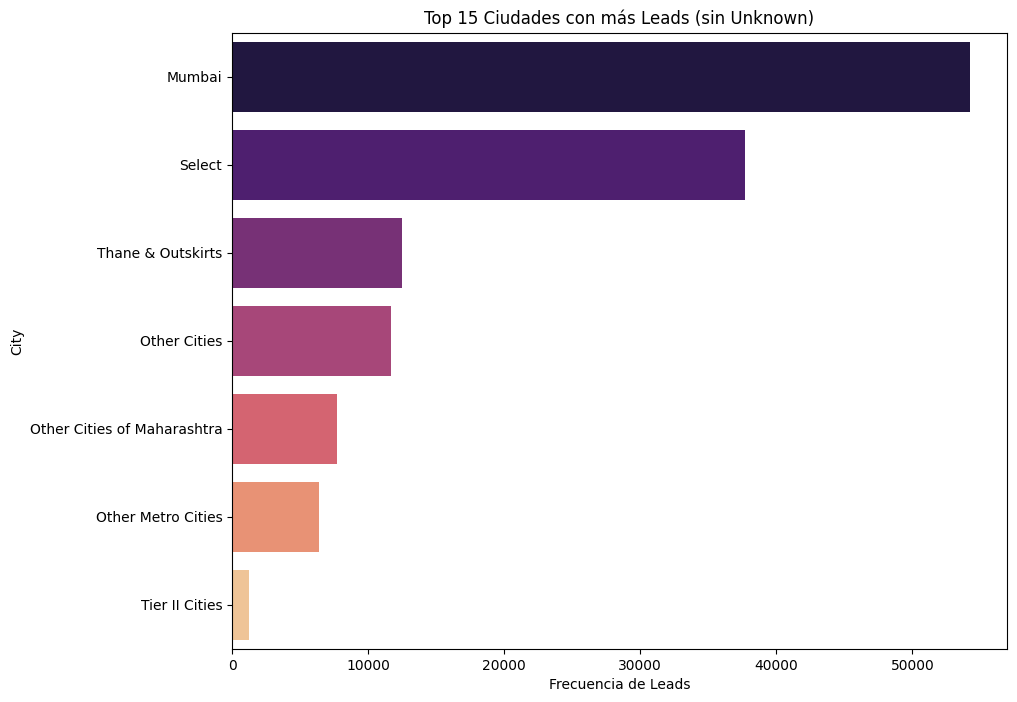

In [670]:

# Filtrar 'Unknown' del dataframe
filtered_data = data_frame_leads[data_frame_leads['City'] != 'Unknown']

# Agrupar por ciudad y contar ocurrencias
city_counts = filtered_data['City'].value_counts()

# Mostrar las 15 ciudades con más leads
top_cities = city_counts.nlargest(15)

# Crear el gráfico (horizontal para mayor claridad)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="magma")

# Añadir etiquetas y título
plt.title('Top 15 Ciudades con más Leads (sin Unknown)')
plt.xlabel('Frecuencia de Leads')
plt.ylabel('City')

plt.show()



# Observaciones: Ciudades con más Leads (sin Unknown)

## Top 15 Ciudades con más Leads
- **Observación Clave**:  
  - La ciudad con mayor cantidad de leads es **South Michael**, seguida por **East Michael** y **Port Michael**.  
  - La distribución muestra una clara concentración de leads en estas tres ciudades, lo que podría indicar una mayor demanda o presencia de mercado en esas áreas.  

- **Interpretación**:  
  - La eliminación de la categoría **"Unknown"** permite obtener una visión más precisa de las ciudades con mayor actividad de leads.  
  - La dispersión de leads en diferentes ciudades también sugiere la necesidad de estrategias locales para maximizar conversiones.  


**Variables Numericas**

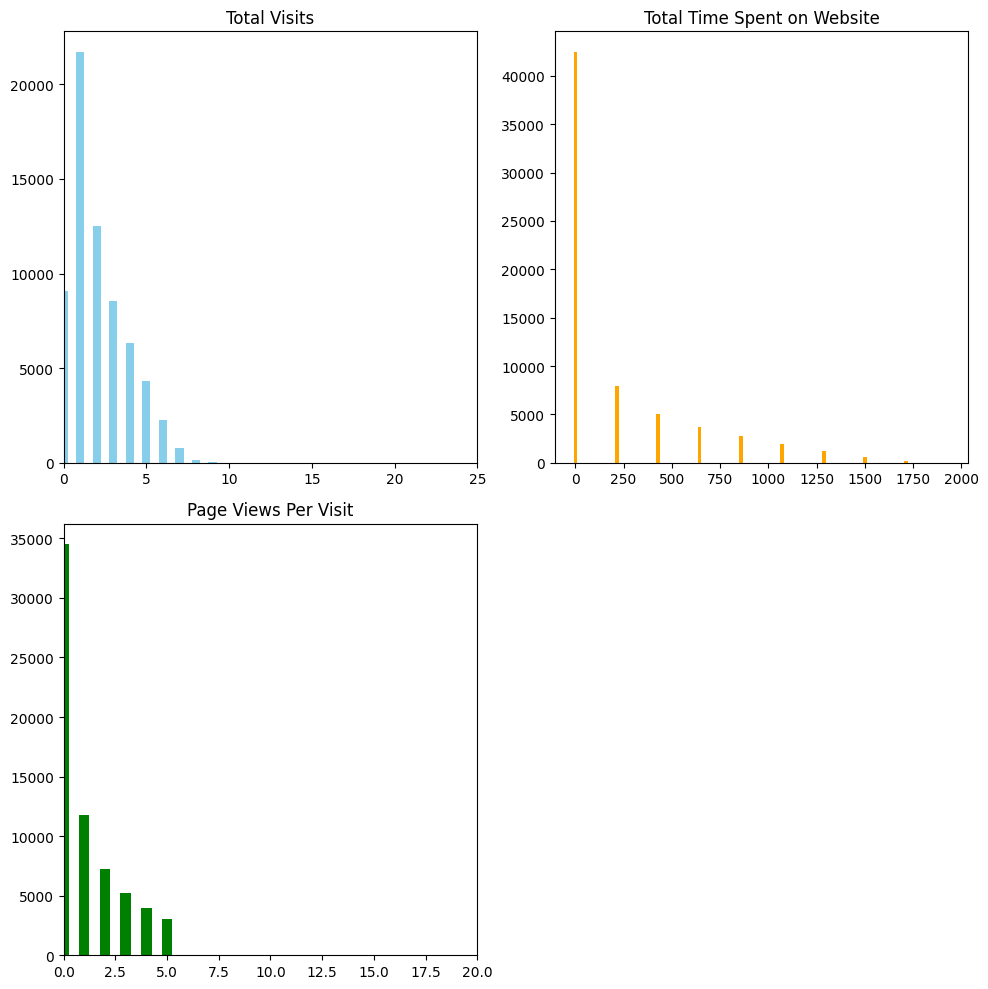

In [671]:

# Muestra aleatoria (50% del dataset o 50k filas)
sample_data = data_frame_leads.sample(frac=0.5, random_state=42)

plt.figure(figsize=(10, 10))

# Histograma para 'Total Visits'
plt.subplot(221)
hist_visits, bins_visits = np.histogram(sample_data['TotalVisits'], bins=50, range=(0, 25))
plt.bar(bins_visits[:-1], hist_visits, width=0.5, color='skyblue')
plt.title('Total Visits')
plt.xlim(0, 25)

# Histograma para 'Total Time Spent on Website'
plt.subplot(222)
hist_time, bins_time = np.histogram(sample_data['Total Time Spent on Website'], bins=10)
plt.bar(bins_time[:-1], hist_time, width=20, color='orange')
plt.title('Total Time Spent on Website')

# Histograma para 'Page Views Per Visit'
plt.subplot(223)
hist_pageviews, bins_pageviews = np.histogram(sample_data['Page Views Per Visit'], bins=20, range=(0, 20))
plt.bar(bins_pageviews[:-1], hist_pageviews, width=0.5, color='green')
plt.title('Page Views Per Visit')
plt.xlim(0, 20)

plt.tight_layout()
plt.show()


# Observación: Análisis de Visitas y Tiempo en la Web

## Distribución de Total Visits, Total Time Spent on Website y Page Views Per Visit
- **Total Visits**: La mayoría de los leads realizaron entre **1 y 5 visitas**, con una fuerte caída en visitas superiores a este rango. Esto sugiere que la mayoría de los usuarios no regresan repetidamente al sitio.  
- **Total Time Spent on Website**: Se observa una distribución sesgada a la izquierda, donde la mayoría de los usuarios pasan menos de **250 segundos** en el sitio. Este comportamiento podría indicar que los usuarios encuentran rápidamente lo que buscan o abandonan la web tras una breve navegación.  
- **Page Views Per Visit**: La mayoría de los leads realizan entre **1 y 3 vistas** por visita. Esta tendencia refuerza la idea de que los usuarios no navegan profundamente en el sitio durante sus visitas.  


**Bivariate Analysis**

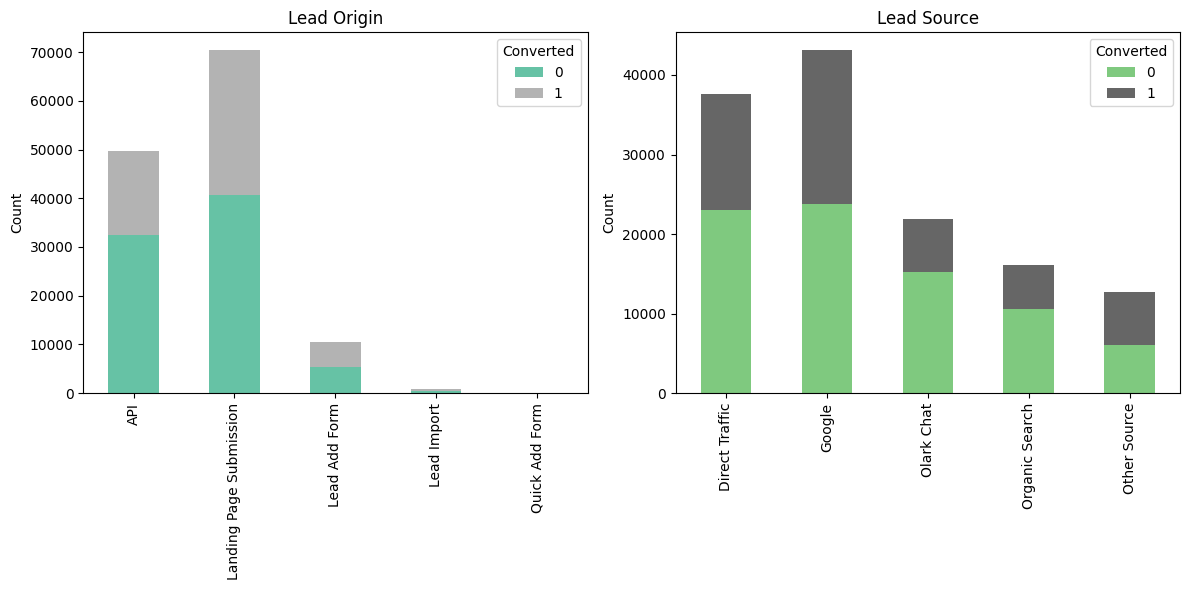

In [672]:

# Muestreo opcional para grandes datasets (descomentar si es necesario)
# data_sample = data_frame_leads.sample(frac=0.5, random_state=42)  
data_sample = data_frame_leads  # Usamos el dataset completo si no hay problemas de rendimiento

# Precalcular los valores para las gráficas
lead_origin_counts = pd.crosstab(data_sample['Lead Origin'], data_sample['Converted'])
lead_source_counts = pd.crosstab(data_sample['Lead Source'], data_sample['Converted'])

# Gráfico
plt.figure(figsize=(12, 6))

# Lead Origin
plt.subplot(1, 2, 1)
lead_origin_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set2')
plt.title('Lead Origin')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

# Lead Source
plt.subplot(1, 2, 2)
lead_source_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Accent')
plt.title('Lead Source')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Observación: Análisis de Origen y Fuente de Leads

## Lead Origin y Lead Source
- **Lead Origin**: La mayoría de los leads provienen de **Landing Page Submission** y **API**, destacando la importancia de estos canales en la captación de leads. Sin embargo, hay una alta proporción de leads no convertidos en ambos orígenes, lo que sugiere la necesidad de optimizar la conversión en estos puntos.  
- **Lead Source**: **Google** y **Direct Traffic** representan las principales fuentes de tráfico. A pesar de tener un número significativo de conversiones, también hay una gran cantidad de leads no convertidos. El tráfico de **Olark Chat** y **Organic Search** muestra tasas de conversión moderadas, lo que indica que estos canales podrían necesitar una estrategia de engagement más efectiva.  

**Conclusión**: La optimización de las páginas de destino y una mejor segmentación del tráfico directo y de Google podrían mejorar significativamente las tasas de conversión.  


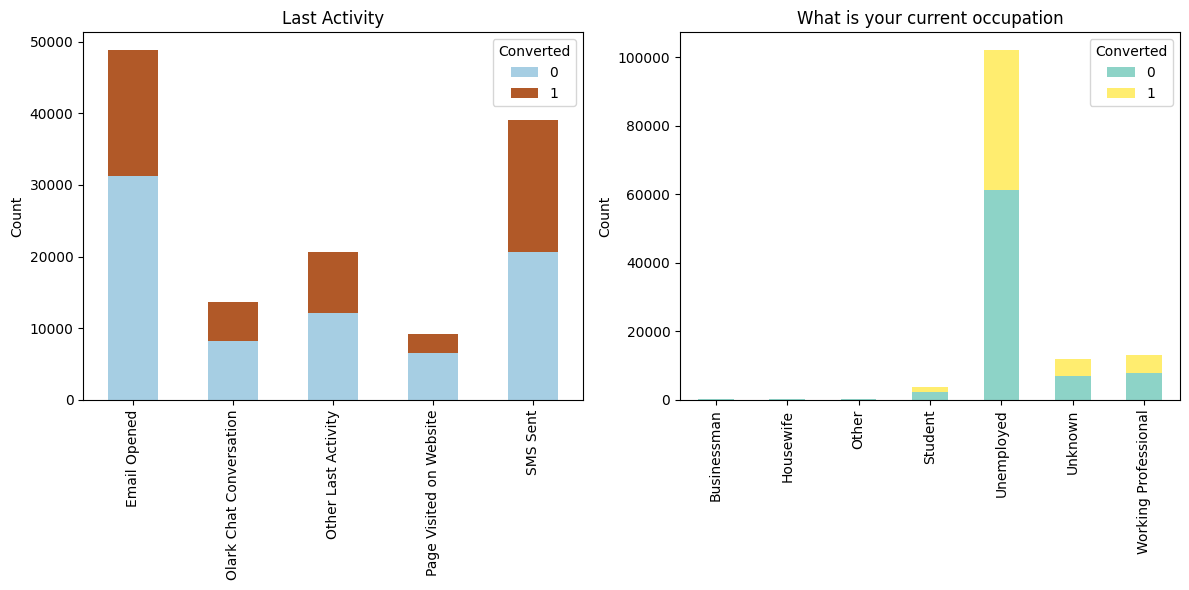

In [673]:
# Muestreo opcional para mejorar rendimiento (descomentar si es necesario)
# data_sample = data_frame_leads.sample(frac=0.5, random_state=42)
data_sample = data_frame_leads  # Usamos el dataset completo si no hay problemas de rendimiento

# Pre-calcular valores para las gráficas
activity_counts = pd.crosstab(data_sample['Last Activity'], data_sample['Converted'])
occupation_counts = pd.crosstab(data_sample['What is your current occupation'], data_sample['Converted'])

# Gráfico
plt.figure(figsize=(12, 6))

# Last Activity
plt.subplot(1, 2, 1)
activity_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Paired')
plt.title('Last Activity')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

# Current Occupation
plt.subplot(1, 2, 2)
occupation_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set3')
plt.title('What is your current occupation')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Observación: Actividad Final e Información Ocupacional

## Last Activity y Current Occupation
- **Last Activity**: La apertura de correos electrónicos y el envío de SMS son las actividades finales más comunes. Sin embargo, **SMS Sent** tiene una tasa de conversión notablemente más alta que **Email Opened**, lo que sugiere que el envío de SMS podría ser un canal más efectivo para impulsar conversiones. Las actividades como **Olark Chat Conversation** y **Page Visited on Website** muestran tasas de conversión más bajas.  
- **Current Occupation**: La mayoría de los leads provienen de personas desempleadas (**Unemployed**) y de aquellos cuya ocupación es desconocida (**Unknown**). Los leads con ocupación desconocida también presentan una tasa de conversión significativa, lo que sugiere que este grupo no debe ser subestimado a pesar de la falta de información detallada.  

**Conclusión**: Las estrategias de marketing deberían enfocarse en maximizar el impacto de los SMS y mejorar el engagement con leads desempleados, así como explorar formas de segmentar mejor a aquellos con ocupación desconocida.  


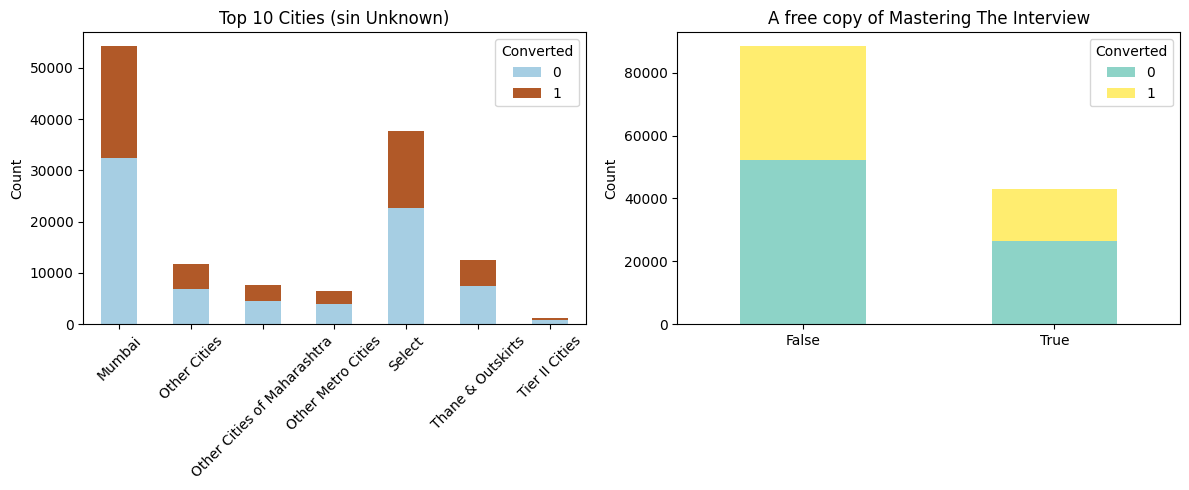

In [674]:
# Filtrar ciudades que no sean 'Unknown'
data_sample_filtered = data_sample[data_sample['City'] != 'Unknown']

# Calcular top 10 ciudades sin 'Unknown'
top_cities_filtered = data_sample_filtered['City'].value_counts().nlargest(10).index
city_counts_filtered = data_sample_filtered[data_sample_filtered['City'].isin(top_cities_filtered)] \
                        .groupby(['City', 'Converted']).size().unstack(fill_value=0)

# Calcular conteo de 'A free copy of Mastering The Interview' frente a conversiones
copy_counts = pd.crosstab(data_sample['A free copy of Mastering The Interview'], data_sample['Converted'])

# Gráfico optimizado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# City sin 'Unknown'
city_counts_filtered.plot(kind='bar', stacked=True, ax=axes[0], colormap='Paired')
axes[0].set_title('Top 10 Cities (sin Unknown)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')

# A free copy of Mastering The Interview
copy_counts.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set3')
axes[1].set_title('A free copy of Mastering The Interview')
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_xlabel('')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()



** VVEREMOS SI HAY QUE MODIFICAR ALGO **

Text(0.5, 1.0, 'Last Notable Activity')

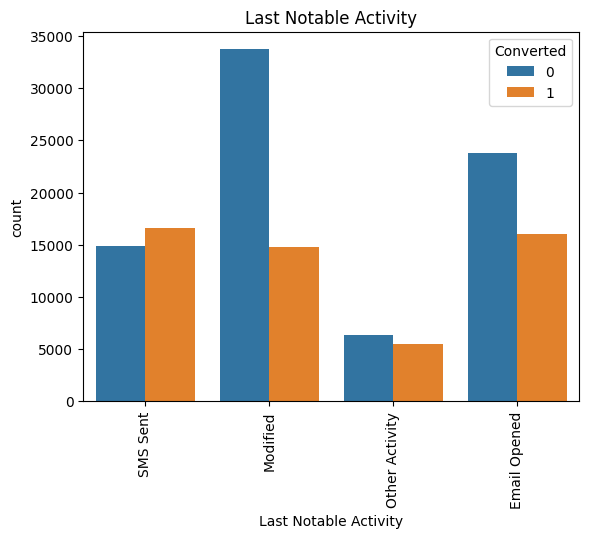

In [675]:
sns.countplot(x='Last Notable Activity', hue='Converted', data= data_frame_leads).tick_params(axis='x', rotation = 90)
plt.title('Last Notable Activity')

### Observación:
El gráfico muestra la actividad notable más reciente de los leads y su relación con la conversión. Se observa que las actividades **"Modified"** y **"Email Opened"** son las más comunes, pero presentan una menor tasa de conversión en comparación con otras. **"SMS Sent"** destaca por tener una distribución más equilibrada entre convertidos y no convertidos, lo que podría indicar que este tipo de actividad genera un mayor nivel de interés o engagement. Por otro lado, **"Other Activity"** tiene una baja frecuencia general, lo que podría sugerir que los leads con actividades menos relevantes o específicas tienden a tener menores tasas de conversión.


/var/folders/9f/2dqd0jwj1gx3t_n_0tk79_180000gq/T/ipykernel_46580/1525600889.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_sample, x='Converted', y='Lead Number', palette='Set2')


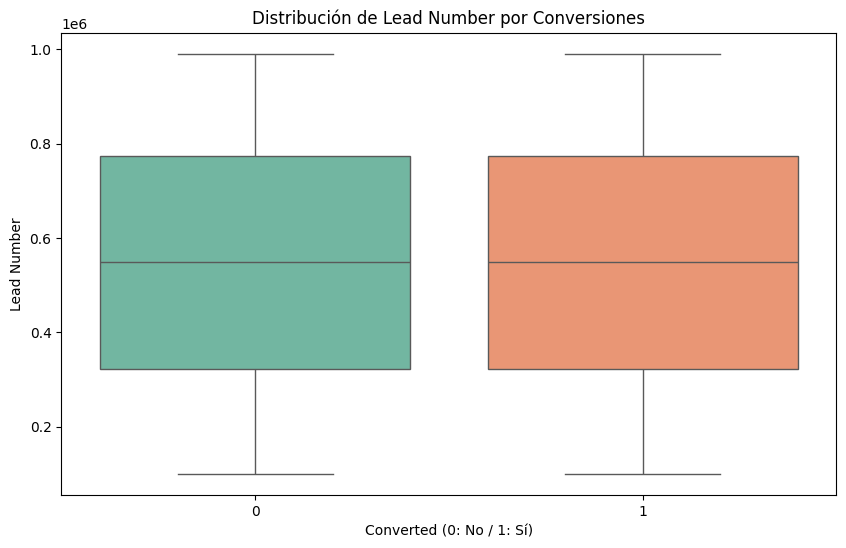

In [676]:

# Muestreo opcional (reducir si el dataset es muy grande)
data_sample = data_frame_leads.sample(frac=0.6, random_state=42)  # Toma el 60% del dataset

# Limitar el rango de Lead Number para evitar outliers extremos visuales
data_sample['Lead Number'] = data_sample['Lead Number'].clip(upper=data_sample['Lead Number'].quantile(0.99))

# Graficar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_sample, x='Converted', y='Lead Number', palette='Set2')

plt.title('Distribución de Lead Number por Conversiones')
plt.ylabel('Lead Number')
plt.xlabel('Converted (0: No / 1: Sí)')
plt.show()


### Observación:
El boxplot muestra la distribución del número de lead en función de si estos se convirtieron (1) o no (0). Se observa que las distribuciones son muy similares en ambas categorías, lo que sugiere que **el número de lead no tiene un impacto significativo en la conversión**. Los valores atípicos (outliers) están presentes en ambos grupos, pero no parece haber una diferencia notable en las medianas ni en el rango intercuartílico (IQR). Esta gráfica indica que probablemente el número de lead **no es un predictor relevante** para determinar la probabilidad de conversión.


**Observación**


## DATA PREPARATION ##

**Convertir el tipo de datos de alguna variables (YES/NO) a 0/1**

In [677]:
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].map({'True': True, 'False': False})
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].astype(int)


In [678]:
print(data_frame_leads['A free copy of Mastering The Interview'].value_counts())


A free copy of Mastering The Interview
0    88415
1    43097
Name: count, dtype: int64


In [679]:
data_frame_leads.head()

,Lead Number,Lead Origin,Lead Source,Converted,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,A free copy of Mastering The Interview,Tags,City,Last Notable Activity,TotalVisits,Specialization,Average Time Per Visit
605,417704,Lead Add Form,Other Source,1,3,0.24,SMS Sent,Unemployed,0,Ringing,Select,SMS Sent,0.0,Business Administration,97.106819
606,706927,Landing Page Submission,Other Source,1,4,0.23,Email Opened,Unemployed,0,Will revert after reading the email,Select,Modified,0.0,Operations Management,97.106819
609,999870,Landing Page Submission,Other Source,1,4,0.09,Page Visited on Website,Unemployed,0,Interested in other courses,Mumbai,Modified,0.0,Finance Management,97.106819
610,361615,Landing Page Submission,Other Source,1,8,0.14,Email Opened,Unemployed,0,Other Tags,Mumbai,Modified,0.0,Marketing Management,97.106819
611,608701,Landing Page Submission,Other Source,1,2,0.08,SMS Sent,Unemployed,0,Will revert after reading the email,Select,Other Activity,0.0,Operations Management,97.106819


In [680]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview      int64
Tags                                       object
City                                       object
Last Notable Activity                      object
TotalVisits                               float64
Specialization                             object
Average Time Per Visit                    float64
dtype: object

**Para las variables categóricas con multiples niveles, se han creado algunos dummy features**

In [681]:
catColumns=['Lead Origin','Lead Source','Last Activity','Specialization','What is your current occupation','Tags','City','Last Notable Activity']
catColumns

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Specialization',
 'What is your current occupation',
 'Tags',
 'City',
 'Last Notable Activity']

In [682]:
dummyVariable = pd.get_dummies(data_frame_leads[catColumns], drop_first=True).astype(int)
dummyVariable.head()

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
605,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
606,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
609,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
610,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
611,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [683]:
dummyVariable.shape

(131512, 47)

In [684]:
# Add the results to the original bike dataframe
data_frame_leads = pd.concat([data_frame_leads,dummyVariable], axis = 1)

In [685]:
data_frame_leads.head()

,Lead Number,Lead Origin,Lead Source,Converted,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,A free copy of Mastering The Interview,Tags,City,Last Notable Activity,TotalVisits,Specialization,Average Time Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
605,417704,Lead Add Form,Other Source,1,3,0.24,SMS Sent,Unemployed,0,Ringing,Select,SMS Sent,0.0,Business Administration,97.106819,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
606,706927,Landing Page Submission,Other Source,1,4,0.23,Email Opened,Unemployed,0,Will revert after reading the email,Select,Modified,0.0,Operations Management,97.106819,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
609,999870,Landing Page Submission,Other Source,1,4,0.09,Page Visited on Website,Unemployed,0,Interested in other courses,Mumbai,Modified,0.0,Finance Management,97.106819,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
610,361615,Landing Page Submission,Other Source,1,8,0.14,Email Opened,Unemployed,0,Other Tags,Mumbai,Modified,0.0,Marketing Management,97.106819,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
611,608701,Landing Page Submission,Other Source,1,2,0.08,SMS Sent,Unemployed,0,Will revert after reading the email,Select,Other Activity,0.0,Operations Management,97.106819,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [686]:
data_frame_leads.shape

(131512, 62)

**Decisión de eliminar las columnas**

In [687]:
# Drop columns for which we have created the dummies
data_frame_leads.drop(catColumns, axis = 1, inplace = True)

In [688]:
data_frame_leads.head()

,Lead Number,Converted,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
605,417704,1,3,0.24,0,0.0,97.106819,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
606,706927,1,4,0.23,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
609,999870,1,4,0.09,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
610,361615,1,8,0.14,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
611,608701,1,2,0.08,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [689]:
data_frame_leads.shape

(131512, 54)

In [690]:
data_frame_leads.head()

,Lead Number,Converted,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
605,417704,1,3,0.24,0,0.0,97.106819,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
606,706927,1,4,0.23,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
609,999870,1,4,0.09,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
610,361615,1,8,0.14,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
611,608701,1,2,0.08,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


**TRAIN - TEST SPLIT**

In [691]:
#Putting feature variable to X
X = data_frame_leads.drop (['Converted'], axis = 1)
X.head()

,Lead Number,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
605,417704,3,0.24,0,0.0,97.106819,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
606,706927,4,0.23,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
609,999870,4,0.09,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
610,361615,8,0.14,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
611,608701,2,0.08,0,0.0,97.106819,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [692]:
#Poniendo el response en la variable y
y = data_frame_leads['Converted']
y.head()

605    1
606    1
609    1
610    1
611    1
Name: Converted, dtype: int64

In [693]:
#Splitting the data into train and test
X_train,X_test,y_train, y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)


## SELECCION DE FEATURES ##

In [694]:
X_train.dtypes

Lead Number                                 int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
A free copy of Mastering The Interview      int64
TotalVisits                               float64
                                           ...   
City_Thane & Outskirts                      int64
City_Tier II Cities                         int64
Last Notable Activity_Modified              int64
Last Notable Activity_Other Activity        int64
Last Notable Activity_SMS Sent              int64
Length: 53, dtype: object

In [695]:
scaler = MinMaxScaler()
X_train[['Lead Number','TotalVisits','Page Views Per Visit','Total Time Spent on Website']] = scaler.fit_transform(X_train[['Lead Number','TotalVisits','Page Views Per Visit','Total Time Spent on Website']])
X_train.head()

,Lead Number,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
15104,0.653031,0.046218,0.161667,1,0.2,50.00,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
653,0.542620,0.273576,0.705000,0,0.4,146.75,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
59448,0.896493,0.183473,0.281667,1,0.2,197.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
125885,0.042584,0.256769,0.638333,0,0.5,110.20,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
106632,0.930807,0.032213,0.165000,0,0.2,35.00,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [696]:
### Checking the Converted Rate
convertRate = (sum(data_frame_leads['Converted'])/len(data_frame_leads['Converted'].index))*100
convertRate

40.15070868057668

In [697]:
X_train.columns


Index(['Lead Number', 'Total Time Spent on Website', 'Page Views Per Visit', 'A free copy of Mastering The Interview', 'TotalVisits', 'Average Time Per Visit', 'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form', 'Lead Origin_Lead Import', 'Lead Origin_Quick Add Form', 'Lead Source_Google', 'Lead Source_Olark Chat', 'Lead Source_Organic Search', 'Lead Source_Other Source', 'Last Activity_Olark Chat Conversation', 'Last Activity_Other Last Activity', 'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent', 'Specialization_Business Administration', 'Specialization_Finance Management', 'Specialization_Healthcare Management', 'Specialization_Human Resource Management', 'Specialization_IT Projects Management', 'Specialization_International Business', 'Specialization_Marketing Management', 'Specialization_Media and Advertising', 'Specialization_Operations Management', 'Specialization_Others', 'Specialization_Supply Chain Management',
       'Specialization_Travel and

## Observacion de Correlaciones ##


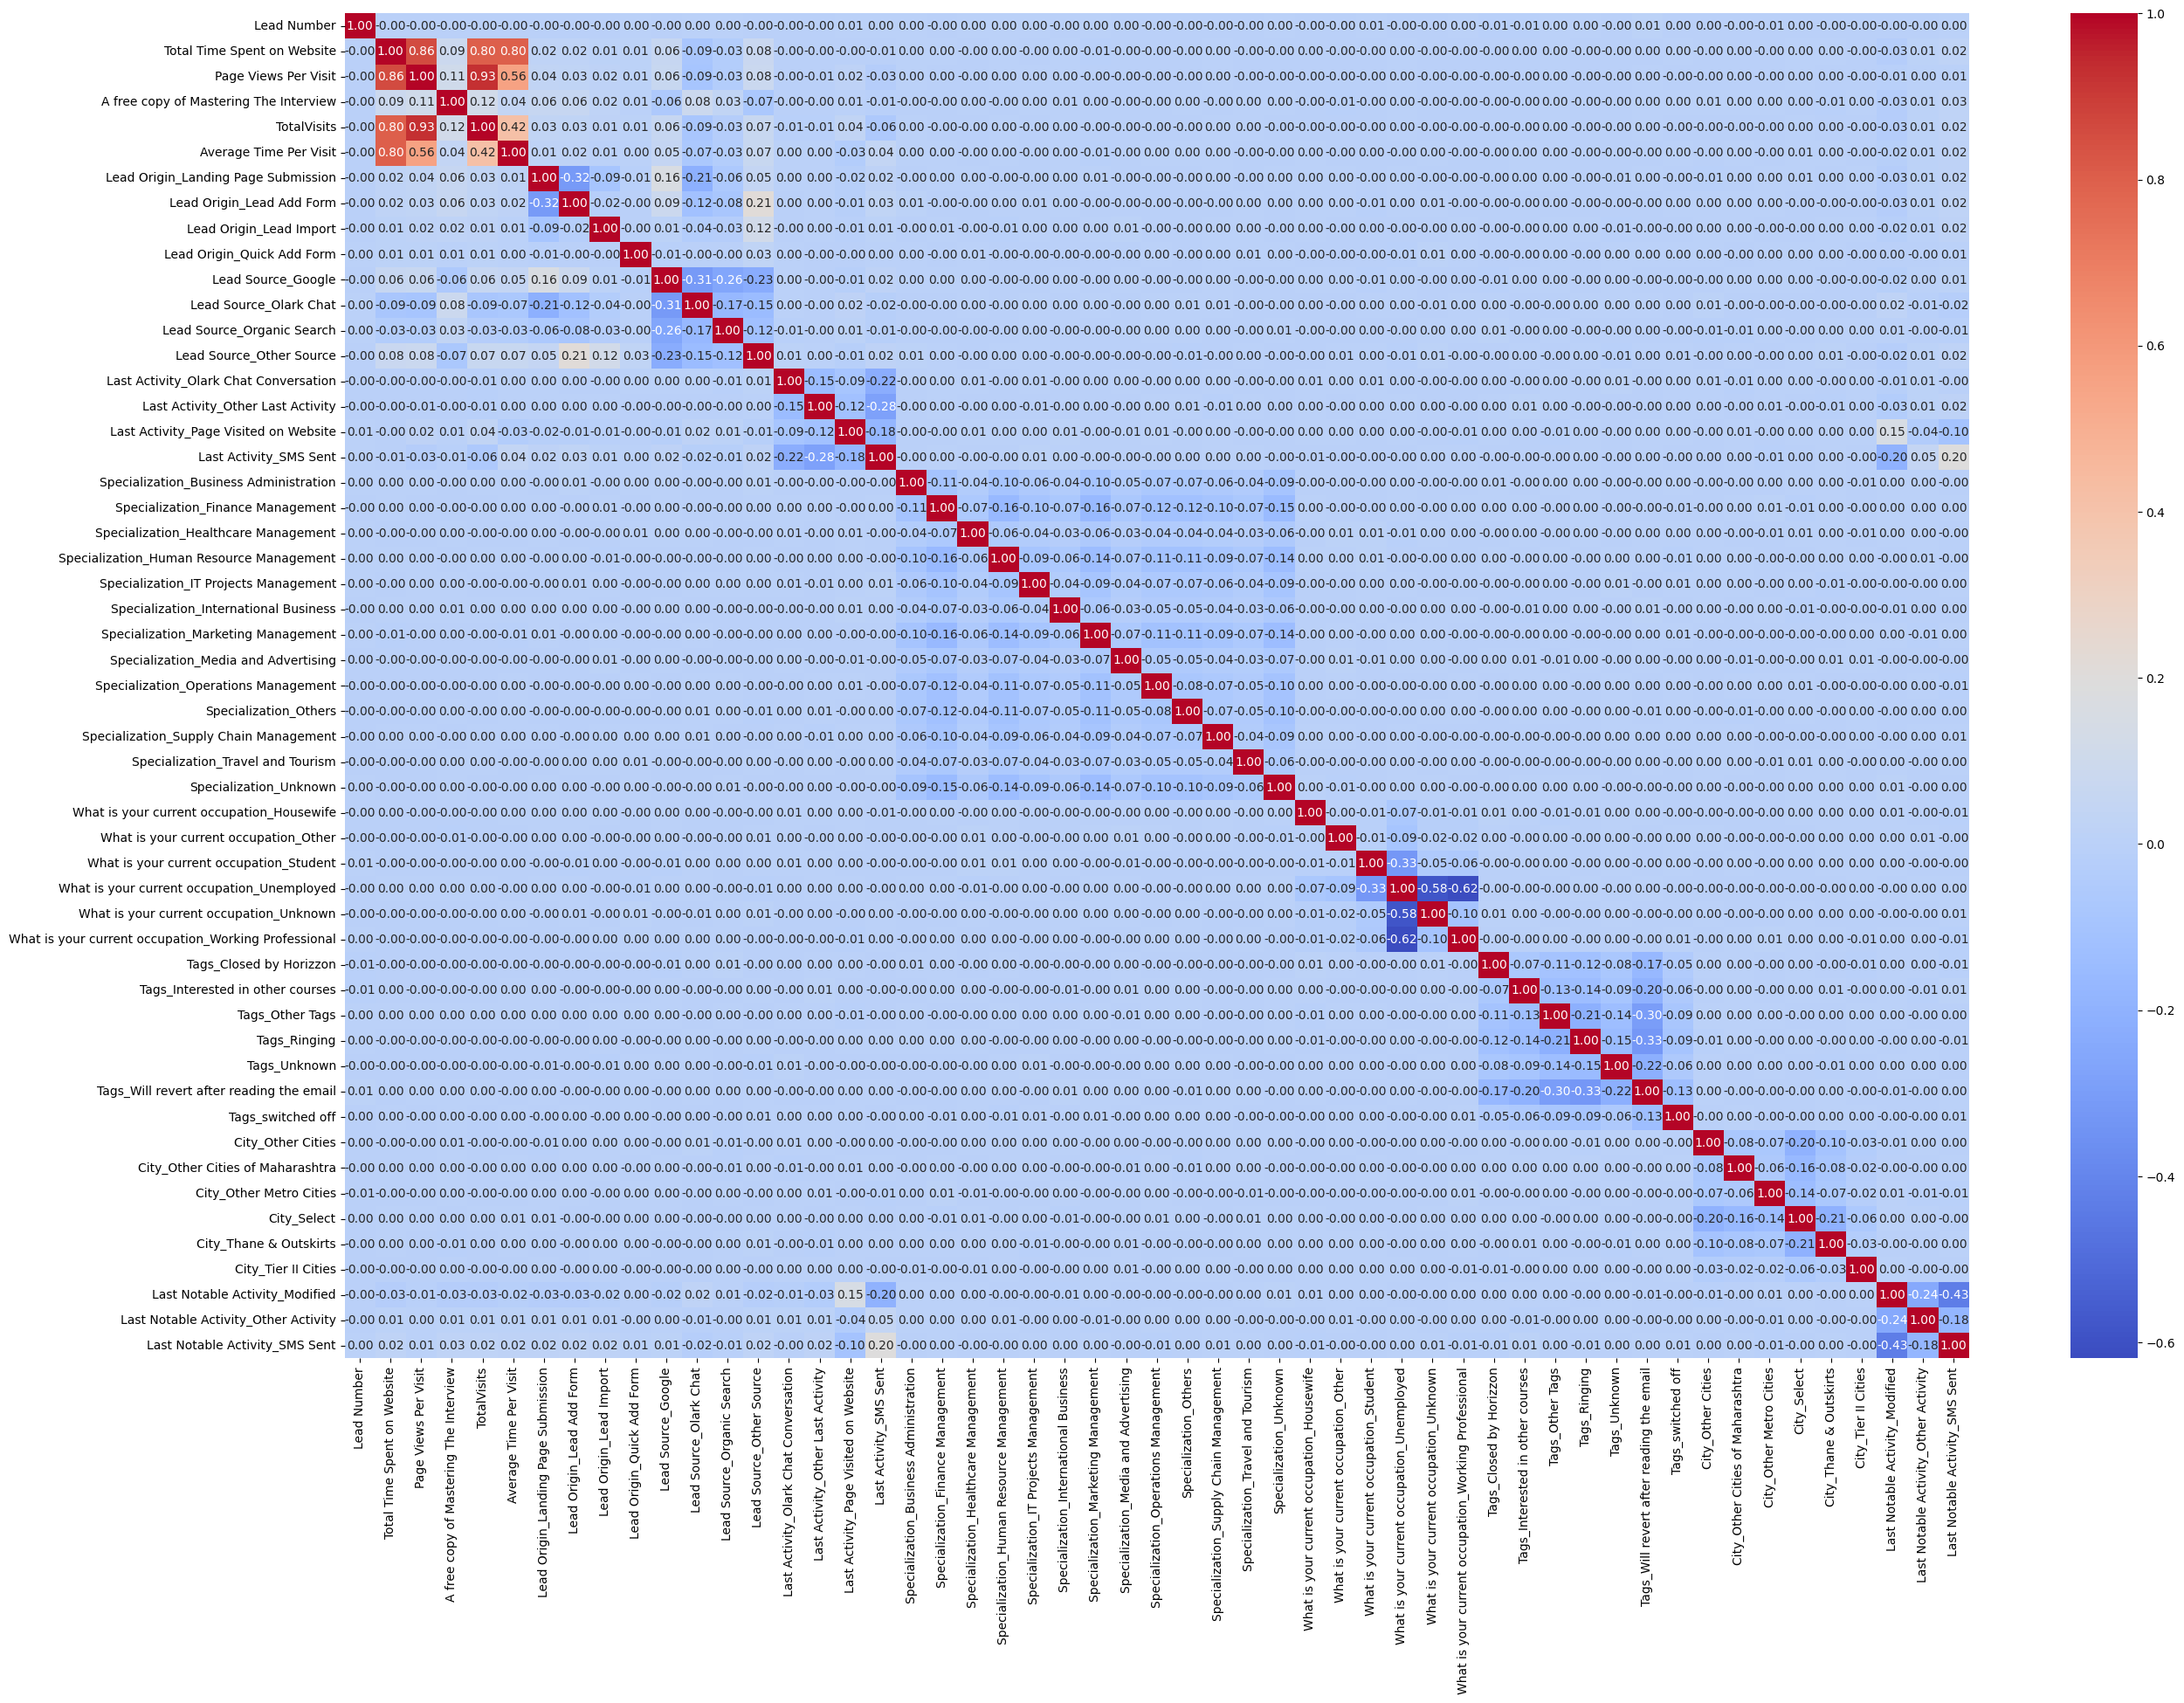

In [698]:
#correlation matrix 
plt.figure(figsize=(30, 20))  # Aumentar tamaño
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


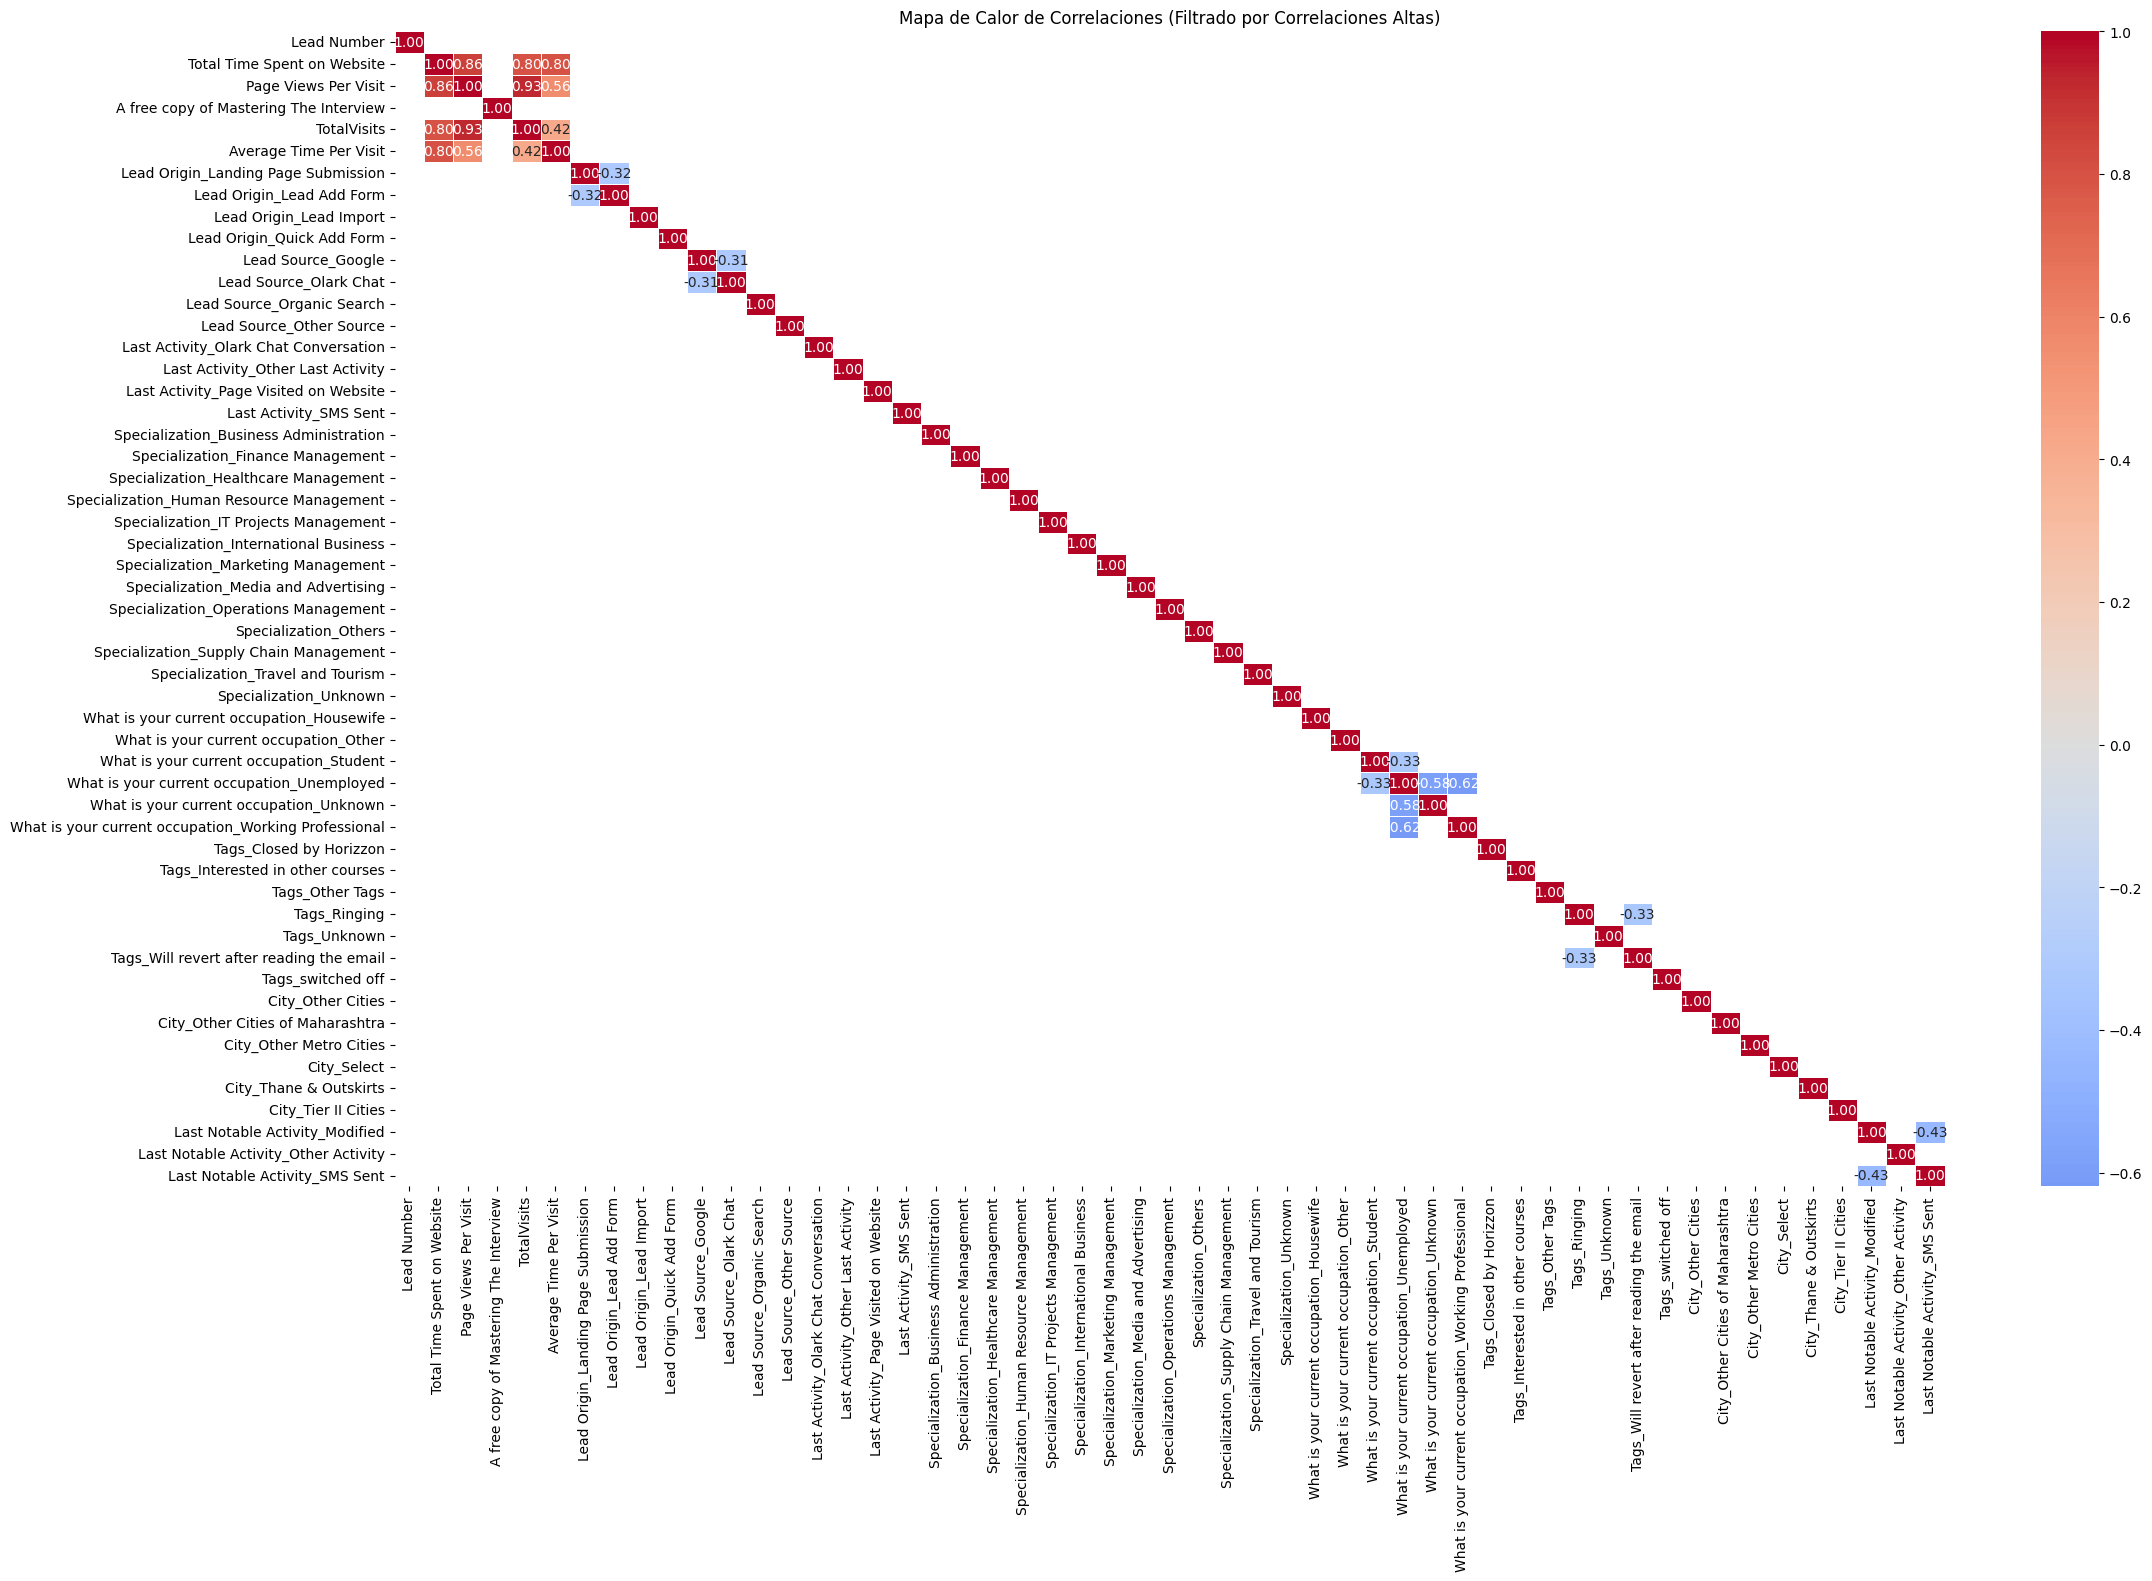

In [701]:
# Calcular la matriz de correlación
correlation_matrix = X_train.corr()

# Filtrar correlaciones altas (por encima de 0.3, ajusta según necesidad)
high_corr = correlation_matrix[(correlation_matrix > 0.3) | (correlation_matrix < -0.3)]

# Graficar el heatmap con anotaciones
plt.figure(figsize=(25, 15))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")

plt.title('Mapa de Calor de Correlaciones (Filtrado por Correlaciones Altas)')
plt.show()

In [702]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split


# 2. Definir el modelo base (Random Forest)
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# 3. Inicializar RFE con Random Forest
rfe = RFE(estimator=model, n_features_to_select=20, step=5)  # step=5 elimina 5 features en cada iteración

# 4. Aplicar RFE a una muestra (50k filas para acelerar)
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=50000, random_state=42)
rfe.fit(X_sample, y_sample)

# 5. Obtener features seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Selected Features: ", selected_features)

# 6. Filtrar X_train y X_test con las mejores features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 7. Entrenar Random Forest con features seleccionadas
final_model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
final_model.fit(X_train_selected, y_train)

# 8. Evaluar el modelo
accuracy = final_model.score(X_test_selected, y_test)
print(f"Accuracy: {accuracy:.2f}")


Selected Features:  Index(['Lead Number', 'Total Time Spent on Website', 'Page Views Per Visit', 'A free copy of Mastering The Interview', 'TotalVisits', 'Average Time Per Visit', 'Lead Origin_Landing Page Submission', 'Lead Source_Google', 'Last Activity_Other Last Activity', 'Specialization_Finance Management', 'Specialization_Human Resource Management', 'Specialization_Marketing Management', 'Specialization_Unknown', 'What is your current occupation_Unemployed', 'Tags_Other Tags', 'Tags_Ringing', 'Tags_Will revert after reading the email', 'City_Select', 'Last Notable Activity_Modified', 'Last Notable Activity_SMS Sent'], dtype='object')
Accuracy: 0.55
